<a href="https://colab.research.google.com/github/Anthony-Ng-20/NLP/blob/main/Exploring_BERT_with_Disaster_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## System set-up

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 3.9MB/s 
     |████████████████████████████████| 1.1MB 3.3MB/s 
     |████████████████████████████████| 645kB 29.3MB/s 
     |████████████████████████████████| 38.2MB 1.5MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 358kB 38.0MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 706kB 40.8MB/s 
     |████████████████████████████████| 174kB 42.7MB/s 
     |████████████████████████████████| 1.2MB 36.9MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

# For generating random selection
import random

## Exploring BERT with Disaster Tweet Classification


## Abstract
In this analysis, we explore the architecture and implementation of BERT with the Disaster Tweet dataset made available by Kaggle. We finetuned BERT for the diaster tweet classification and compared its performance with another transfer learning implementation, pre-trained FastText model with bi-LSTM layers. The BERT model had a final validation score of 79% and outperforms the FastText model by 3% in F-1 score. We also tested the effects of (1) expanding contractions and (2) misspelled words on the binary classification task. Expanding contractions had minimal effect on the performance of both models. Random mispelled words in a tweet does not have significant effect on prediction but mispelled keywords, such as spelling 'earthquake' with 'esrthqake' is significant. This also indicates NLP models rely heavily on keywords to classify disaster tweets. 

## 1 Introduction
In this project, we evaluate BERT on a binary classification problem, compare it's performance to another transfer learning model and understand some model limitations by manipulating the dataset. The used dataset contains disaster tweets and non-disaster tweets. The goal is to correctly classify disaster tweets. <br> <br>

More specifically, we will fine-tune BERT for the disaster tweet classification, compare performances and explore how contractions and misspellings might affect model performances. Specifically, the analysis is organised in the following order:<br><br>

*   Related works - high level review of available research related to our analaysis
*   Methodology - Introduce key concepts of BERT, FastText
*   Evaluation Metric - Introduce and discuss the evaluation metric used for evaluating model performance
*   Data - Discussion and exploration of the chosen disaster tweet data
*   Implementation & Experimentation: <br>

  1.   Finetune BERT
  2.   Implement FastText-LSTM
  3.   Compare performance
  4.   Does contraction affect model performances?
  5.   Does misspelling affect model performances?

*   Final conclusion
*   Further work
*   References

## 2 Related works

This analysis is a combination of three tasks, (1) Explore how to implement BERT in the Tensorflow environment and develop an in-depth understanding of how BERT works. (2) Using BERT to classify tweets, compare its performance with another NLP model. (3) Explore whether word contractions and misspellings would hinder NLP model performances for disaster tweet classification. There are various resources to review relating to the above tasks.<br><br>

Since its publication, BERT has received massive interest from academic research and machine learning practitioners. In particular, we find the work of Sun et al. [2] to be particularly applicable to our analysis. They exhaustively search for the best fine-tuning methods for BERT, specifically for text classification. Part of their conclusion indicates that using the last attention layer is indeed appropriate for text classification. Also, applying a slow learning rate is essential to avoid Catastrophic Forgetting.<br><br>

There are different approaches to text classification for disaster response. For example, Ashktorab et al. [3] used more traditional classification approaches such as sLDA, SVM and logistic regression to classify damage and casualties related tweets. The work of Kabir et al. [4]  is perhaps more similar to this analysis. They proposed a deep neural network that combines bidirectional LSTM layers with an attention layer and CNN layers to classify disaster tweets correctly.<br><br>

In understanding the robustness of BERT and other NLP models to misspelt words, the work by Sun et al. [5] provides good insight. They identified that BERT could be very sensitive to typos.


## 3 Methodology

In this analysis, we will mainly explore BERT and use pretrained FreeText embeddings with bi-directional LSTM layer(s) to compare the performance from BERT. We begin by introducing common concepts between the two model implementations for the reader and dive into the key concepts of the individual models. <br> <br>

**Word embeddings** <br>
Word embedding is used in NLP to create a numerical representation of a word, usually in a real-number valued vector. Becauase of this, word embeddings and word vectors are often used interchangeably. Similarly to our outstanding of languages, words with similar meaning would be closer in the vector space. Word embedding (or vector) from BERT contains 768 real number features, where as embedding from FastText is consisted of 300 features.<br><br>

The critical difference between the embeddings of FastText and BERT is that the word embeddings of BERT is contextual. For example,  the word, bank, in “After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.” would have a different word embedding inside BERT. However, bank in FastText would only have one representation. Contextual word embedding is believed to generate a better understanding of languages and had outperformed models with non-contextual word embedding in competitions. A deep analysis of BERT's embedding can be found [here](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#why-bert-embeddings)<br><br>

**Transfer learning models**<br>
Transfer learning is defined as “the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned.”  [6]

In this context, using BERT and FastText-LSTM are examples of a transfer learning model. BERT is pre-trained on the BookCorpus and the English Wikipedia. To use BERT for various downstream tasks, the user should fine-tune the model for their specific use by stacking other model structure on top of the pre-trained model for specific task. For our analysis, we stacked a linear binary classifier after the enriched embeddings for the classification. 
Similarly, FastText is available with a pre-trained model, and the end-user would go through similar procedures to use the word embeddings in FastText for different tasks. 

When fine-tuning BERT, the embeddings within BERT can change, and that these changes occur mainly in the top layers of BERT [4]. 

### Bidirectional Encoder Representations from Transformers (BERT)

#### **BERT Architecture**


Here, we will discuss key facts of the architecture of BERT and highlight important concepts. Due to time constraint and the purpose of the analysis we will not go into the full details associated with BERT. Specifically, we will discuss the pre-trained model.

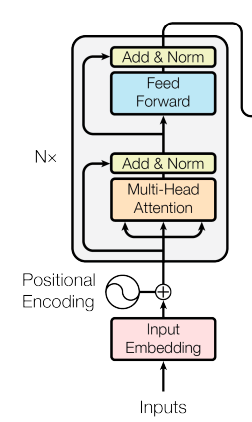

Figure 3.1 - Transformer(& BERT) decoder architecture.<br> Source: "Attention Is All You Need" p.3

The version of BERT we are experimenting is the base version. It is consisted of 12 Transformer [7] encoder layers. As the above illustration demonstrates, each encoder layer is consisted of an multi-head attention layer, an add & norm layer, an feed forward layer and finally an add & norm layer again. The add & norm layer represents a standard residual connection followed by layer normalisation. The feed-forward layer is a full-connected implementation and is consists of two linear transformation with a ReLU activation in between [7]. Essentially, the implementation of the encoder is identical to the original transformer implementation but the number of hidden features are 768 in the base BERT, instead of 512 in the original transformer implementation. We will explain the attention layer in more detail since this is the critical component to transformer-based models.

#### **Self-attention**

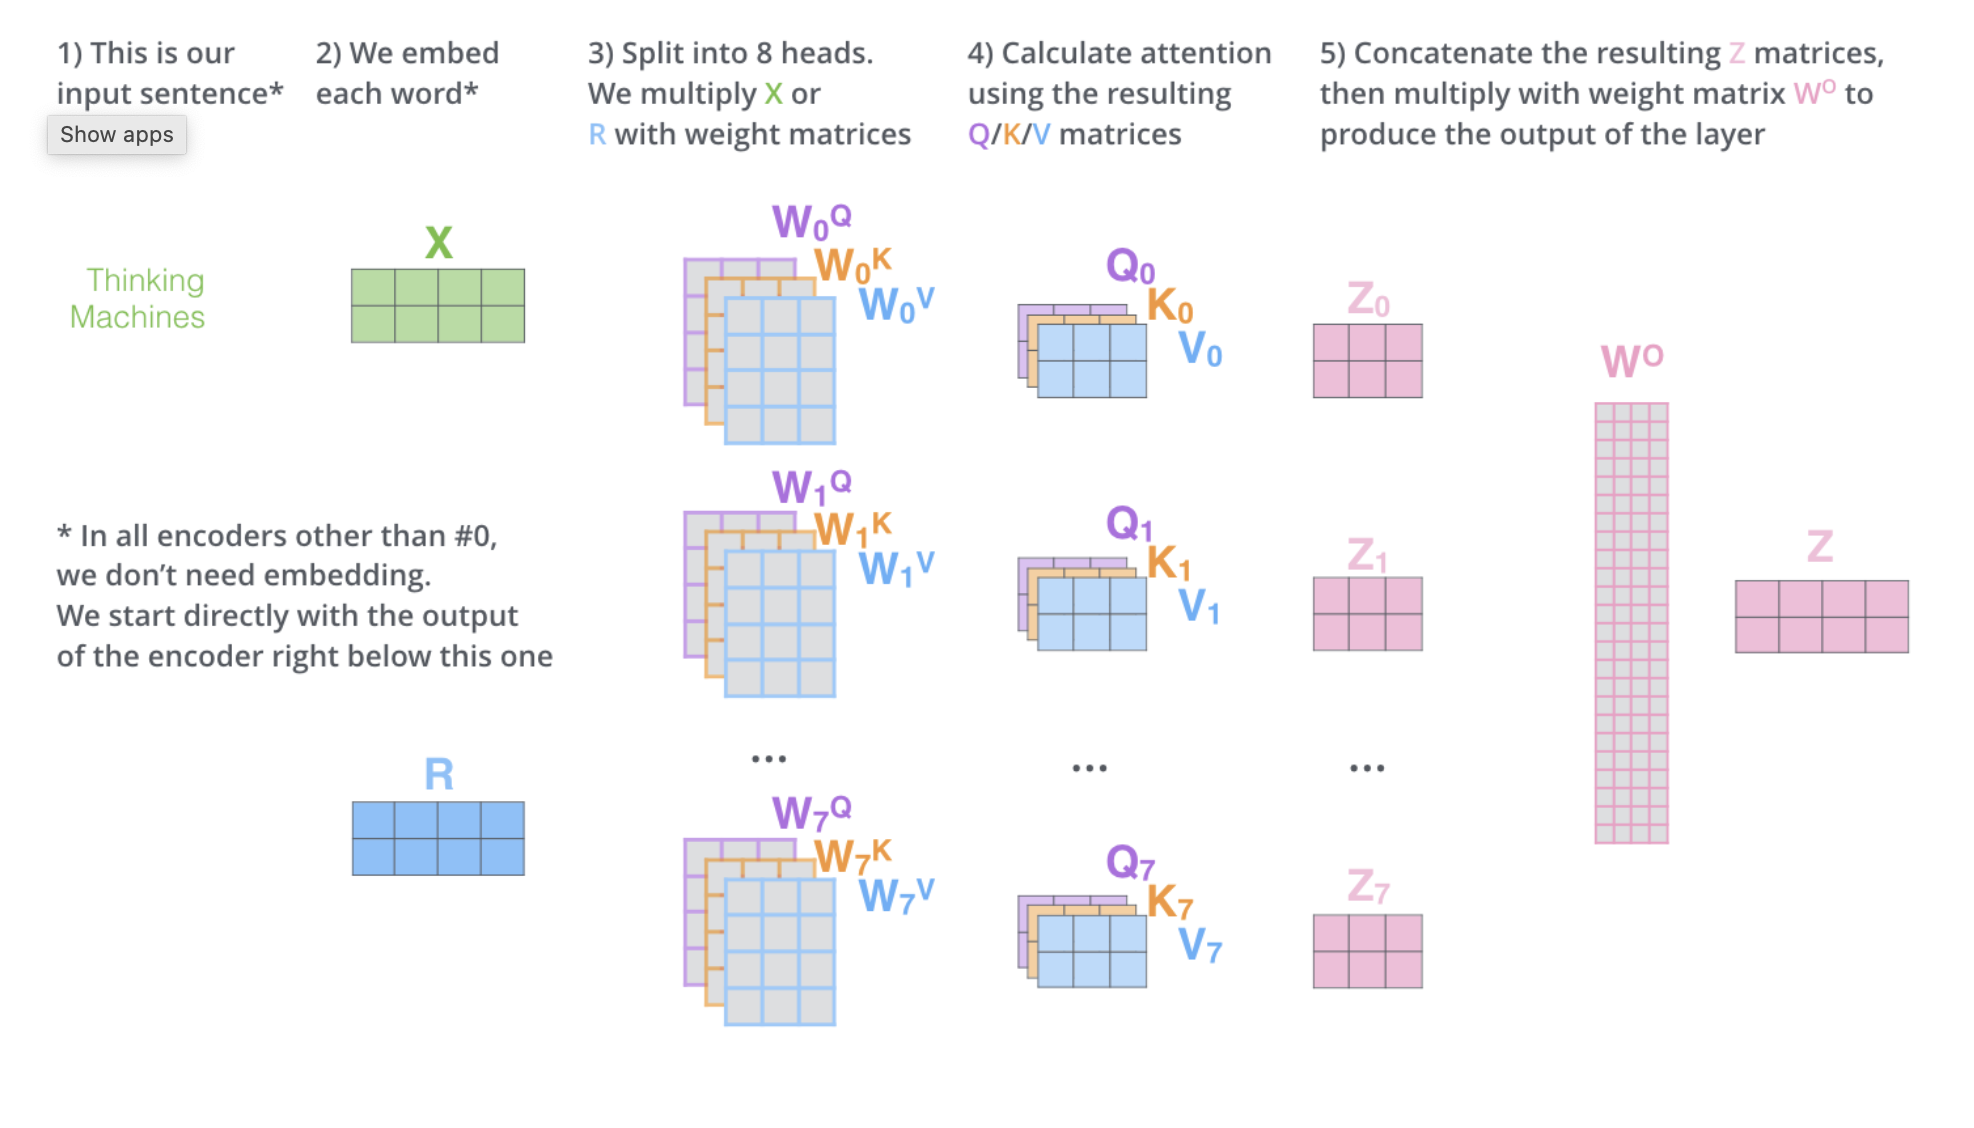

Figure 3.2 - Multi-head attention diagram. Source: [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)

Self-attention is the key concept to BERT and it has been attributed to be the key component that makes transformer based model outperform other models and have a deeper understanding of language. After all, the original transformer paper is named "Attention is all you need" for a reason!

Essentially, self-attention of an input word embedding is a weighted average of embeddings within the entire input. It allows for stronger association of words within the input due to its non-directional nature of how it process inputs as compare to LSTM. For example, in the sentence : "Ernie is my dog, I really adore him." The self-attention mechanism in BERT should show similar enhanced embeddings for the word 'Ernie', 'dog' and 'him' since they refer to the same thing. On the other hand, LSTM networks might be less able to detect association between 'Ernie' and 'dog' as these words are far apart. <br> <br>
As the above diagram illustrates, there are several steps to calculate the attention matrix, we calculate self-attention by multiplying word embeddings to weights of the query, key and value matrix. Once we derive the Q,K,V matrix, self attention is calculated using the below equation. After that, multiple 'heads' of attention layers are weighted as well to produce one attention output. Please note that, there is 9 attention heads in the base BERT model and we will also experiement with the base BERT model in the implementation phase. <br> <br>



Concisely, given matrix Q,K and V, we may calculate attention according to the formula below:
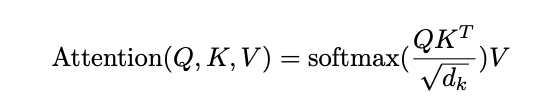 <br>
and final multi-head attention is calculated as follows: <br> <br>
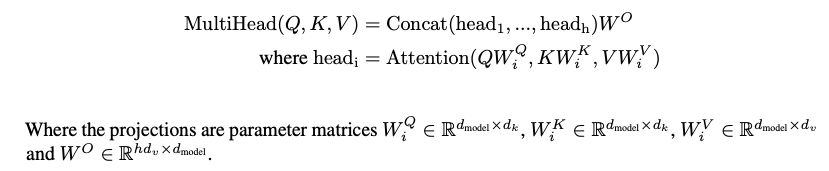

#### **Pre-training tasks of BERT**

In the pre-training phase, BERT is required to perform two tasks, Masked Language Model (MLM) and Next Sentence Prediction (NSP). In essence, BERT has to predict the words that have been masked in a body of text and also determine whether some sentence is the correct one following the previous sentence. These tasks are very computationally expensive to perform but the results is that BERT is able to develop a deep understand of the language. The pre-trained BERT is made opensourced. <br> <br>

### FastText

To compare performance with BERT, we used a FastText pre-trained word embeddings made available by Mikolov et al.[8]. In this section, we highlight the key concepts of the FastText embeddings, full techncial details of how the authors trained the FastText embedding should be referred to the paper. 



#### **Continuous Bag of Words (CBOW)**


FastText is a set of pretrained word embdeddings and it was learned by using a CBOW model with a number of already well-known enhancements. The main task used to train CBOW model is to predict the right centre word  given the surrounding words. The number of surrounding words are bounded by a context window of a specified fixed length. Furthermore, the centre word embeddings are the average of the surrounding word embeddings and hence the name "bag of words" and also because the model does not take in any positional information. 

#### **Position-dependent Weighting, Phrase Representation, Subword Information**



As mentioned, the FastText model used additional enhancements to improve the model. Namely these are (1) position-dependent weighting, (2) phrase representation and (3) subword information. <br><br>

The standard CBOW model does not incorporate positional information, this is what (1) tries to fix. The enhacement is rather simple. Each position in the context window is now associated with a position vector. During the averaging of word vectors to derive the centre word vector, we also use the position vectors to weight the surrounding word vectors. This will have the effect to reflect positional information. (2) is used to further capture richer information, namely to tackle phrases learning as the CBOW mdoel is only based on unigrams. For example, "New" and "York" would have low association with each other if it was learned from context such as "He bought a new car" and "York is a city in England". Phrase representation allows the model to improve representation for phrases such as "New_York" and "New_York_University".(3) helps to compute representations of rare or mispelled words. The enhancement decomposes a single word to a set of n-grams with 3 to 6 characters. Representation is learned for these n-gram representations and the final word vector is simply the addition of the original word vector and the average of the n-gram vectors.

## 4 The Evaluation Metrics

In this analysis, we will discuss the model performance using accuracy, precision, recall, and F1-score. We will use F1-score primiarly to choose the best performing model. <br><br>

We shall clearly define the definition of the various metric to avoid confusion. We assumed that the reader is familiar with a confusion matrix and how to calculate its components (if not, the reader may refer to https://en.wikipedia.org/wiki/Confusion_matrix).<br><br>



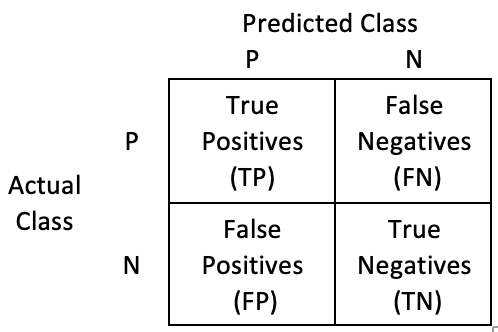


Accuracy is perhaps the most used measure in many different problems. It simply describes the proportion of the instances that the model correctly classified. However, it is not a very comprehensive evaluation metric, especially when the dataset is imbalanced.  For example, if our dataset comprises 10% real natural disaster tweets and 90% of other tweets, a model that always predicts no will achieve 90% accuracy. However, we will never identify an actual disaster tweet with this model and defeats the prediction purpose. <br><br>

Recall and precision together provide a more comprehensive view.
We define *recall* as TP/(TP+FN). 100% in recall means we have correctly classified all the positive instances in the data. However, this metric does not penalise false-positive cases. A model that always classifies instances as positive will score 100% recall, but this model is undoubtedly not a good one. Hence, this is why we need to look at precision at the same time. We define *precision* as TP/(TP+FP). Using our previous example in the recall case, the same model will not score perfectly under precision as this metric penalises false-positive instances.  <br><br>

Our discussion above leads us to the F1 score. We define *F1 score* as 2 * recall * precision/(recall+precision). F1 score is the harmonic mean of recall and precision. Hence 100% in F1 score would mean precision and recall are both 100%. <br><br>

Using F1 score would mean we treat precision and recall equally, which is open to interpretation. In the context of disaster tweet, some would argue that recall should be weighted more. A false-negative cases mean a real disaster is ignored. Disasters often lead to significant loss of lives and properties, and hence even one false-negative case could be catastrophic. On the other hand, Some can argue that if we overweight on recall, this would lead to dispatching emergency response teams to false-positive cases. False-dispatching might overstretch the natural disaster team and reduce its ability to react to real disaster, which is equally significant. Since we are working in a general hypothetical case, we will treat precision and recall equally.

###### Declare evaluation metrics & graph plotting functions

In [ ]:
# Implementation of the performance metric
# epsilon is a small value to avoid cases of divide by 0
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Define common evaluation pack for all model evaluations
metrics = [tf.metrics.BinaryAccuracy() , recall_m, precision_m, f1_m]

In [ ]:
# Evaluation plots
def plot_training(trained_model): 
  plot_num_epochs = range(1, len(trained_model.history['loss'])+1)
  plt.figure(figsize=(16,10))
  plt.subplot(2,3,1)
  plt.plot(plot_num_epochs,trained_model.history['loss'], lw=2.0, color='b', label='train')
  plt.plot(plot_num_epochs,trained_model.history['val_loss'], lw=2.0, color='r', label='val')
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy Loss')
  plt.legend(loc='upper left')

  plt.subplot(2,3,2)
  plt.plot(plot_num_epochs,trained_model.history['binary_accuracy'], lw=2.0, color='b', label='train')
  plt.plot(plot_num_epochs,trained_model.history['val_binary_accuracy'], lw=2.0, color='r', label='val')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')

  plt.subplot(2,3,4)
  plt.plot(plot_num_epochs,trained_model.history['f1_m'], lw=2.0, color='b', label='train')
  plt.plot(plot_num_epochs,trained_model.history['val_f1_m'], lw=2.0, color='r', label='val')
  plt.xlabel('Epochs')
  plt.ylabel('F1 Score')
  plt.legend(loc='upper left')

  plt.subplot(2,3,5)
  plt.plot(plot_num_epochs,trained_model.history['precision_m'], lw=2.0, color='b', label='train')
  plt.plot(plot_num_epochs,trained_model.history['val_precision_m'], lw=2.0, color='r', label='val')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend(loc='upper left')

  plt.subplot(2,3,6)
  plt.plot(plot_num_epochs,trained_model.history['recall_m'], lw=2.0, color='b', label='train')
  plt.plot(plot_num_epochs,trained_model.history['val_recall_m'], lw=2.0, color='r', label='val')
  plt.xlabel('Epochs')
  plt.ylabel('Recall')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
# Evaluation plots - 2
def compare_models(model_1,FineTuneDict,label_m1,label_m2): 
  plot_num_epochs_1 = range(1, len(model_1.history['loss'])+1)
  plot_num_epochs_2 = range(1, len(FineTuneDict['loss'])+1)
  plt.figure(figsize=(16,10))
  plt.subplot(2,3,1)
  plt.plot(plot_num_epochs_1,model_1.history['loss'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_loss'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,FineTuneDict['loss'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,FineTuneDict['val_loss'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy Loss')
  plt.legend(loc='upper left')

  plt.subplot(2,3,2)
  plt.plot(plot_num_epochs_1,model_1.history['binary_accuracy'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_binary_accuracy'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,FineTuneDict['binary_accuracy'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,FineTuneDict['val_binary_accuracy'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')

  plt.subplot(2,3,4)
  plt.plot(plot_num_epochs_1,model_1.history['f1_m'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_f1_m'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,FineTuneDict['f1_m'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,FineTuneDict['val_f1_m'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('F1 Score')
  plt.legend(loc='upper left')

  plt.subplot(2,3,5)
  plt.plot(plot_num_epochs_1,model_1.history['precision_m'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_precision_m'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,FineTuneDict['precision_m'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,FineTuneDict['val_precision_m'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend(loc='upper left')

  plt.subplot(2,3,6)
  plt.plot(plot_num_epochs_1,model_1.history['recall_m'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_recall_m'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,FineTuneDict['recall_m'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,FineTuneDict['val_recall_m'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Recall')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
# Evaluation plots - 3 
def compare_models_FT(model_1,model_2,label_m1,label_m2,lgd_1,lgd_2,lgd_3,lgd_4,lgd_5): 
  plot_num_epochs_1 = range(1, len(model_1.history['loss'])+1)
  plot_num_epochs_2 = range(1, len(model_2.history['loss'])+1)
  plt.figure(figsize=(16,10))
  plt.subplot(2,3,1)
  plt.plot(plot_num_epochs_1,model_1.history['loss'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_loss'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,model_2.history['loss'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,model_2.history['val_loss'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy Loss')
  plt.legend(loc=lgd_1)

  plt.subplot(2,3,2)
  plt.plot(plot_num_epochs_1,model_1.history['binary_accuracy'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_binary_accuracy'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,model_2.history['binary_accuracy'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,model_2.history['val_binary_accuracy'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=lgd_2)

  plt.subplot(2,3,4)
  plt.plot(plot_num_epochs_1,model_1.history['f1_m'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_f1_m'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,model_2.history['f1_m'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,model_2.history['val_f1_m'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('F1 Score')
  plt.legend(loc=lgd_3)

  plt.subplot(2,3,5)
  plt.plot(plot_num_epochs_1,model_1.history['precision_m'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_precision_m'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,model_2.history['precision_m'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,model_2.history['val_precision_m'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend(loc=lgd_4)

  plt.subplot(2,3,6)
  plt.plot(plot_num_epochs_1,model_1.history['recall_m'], lw=2.0, color='b', label=f'{label_m1} train')
  plt.plot(plot_num_epochs_1,model_1.history['val_recall_m'], lw=2.0, color='r', label=f'{label_m1} val')
  plt.plot(plot_num_epochs_2,model_2.history['recall_m'], lw=2.0, color='purple', label=f'{label_m2} train')
  plt.plot(plot_num_epochs_2,model_2.history['val_recall_m'], lw=2.0, color='orange', label=f'{label_m2} val')
  plt.xlabel('Epochs')
  plt.ylabel('Recall')
  plt.legend(loc=lgd_5)
  plt.show()

In [ ]:
# To print the final performance of the fitted model
def final_epoch_performance(trained_model):
  last_idx = len(trained_model.history['loss']) -1
  print(f"""Final training loss:{round(trained_model.history['loss'][last_idx],2)}, Final validation loss:{round(trained_model.history['val_loss'][last_idx],2)}""")
  print(f"""Final training F1-score:{round(trained_model.history['f1_m'][last_idx],2)*100}%, Final validation F1-score:{round(trained_model.history['val_f1_m'][last_idx],2)*100}%""")
  print(f"""Final training accuracy:{round(trained_model.history['binary_accuracy'][last_idx],2)*100}%, Final validation accuracy:{round(trained_model.history['val_binary_accuracy'][last_idx],2)*100}%""")


## 5 The Data

The dataset being used is prepared by Kaggle for their "[Natural Language Processing with Disater Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)" Competition. The dataset contains 10876 tweets which were manually classified and it is pre-split to a training set and test set with a 70/30 split. Test set label is only available when the model is submitted for grading hence we cannot commit more for training and validation. It is unknown when these tweets are extracted.

The training and testing data-set is uploaded to a public Github Directory. Since the size of the file is small, we can directly download it. <br><br>

####**The Train set**
The train set contains 7613 instances, which is 70% of the total data available. The dataset has 5 unique attributes:


*   id - a unique identifier for the tweet
*   keyword - A key word associated with the tweet text, this could be NaN
*   location - The location of where the tweet was sent, this could be NaN
*   text - The main body of tweet text
*   target - This describes whether a tweet is describing a real disaster (1) or not (0)

Our analysis will solely use this set for training and validation.  <br><br>

####**The Test set**
The test set contains 3263 instances, 30% of the total data. The test set also shares the same attributes as the train set but without the target. Kaggle has withheld this and can only be known if we submit our predicted results. <br><br>

####**Used Attributes**
As our analysis mainly focuses on how BERT understands language, we will only use the ***text*** attribute to perform classification. The ***text*** attribute contains the body text of tweets.

###### **Read data**



In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

import re 
import string

train_url = 'https://raw.githubusercontent.com/lse-st449-files/ST449_Final_Project_DataSet/main/train.csv'
test_url  = 'https://raw.githubusercontent.com/lse-st449-files/ST449_Final_Project_DataSet/main/test.csv'

raw_train_set = pd.read_csv(train_url)
raw_test_set = pd.read_csv(test_url)

print(f"Instances in train-set: {len(raw_train_set)}, Instances in test-set: {len(raw_test_set)}, Total Instances: {len(raw_train_set)+len(raw_test_set)}")

Instances in train-set: 7613, Instances in test-set: 3263, Total Instances: 10876


In [ ]:
pd.options.display.max_colwidth = 1000 # To display full length of text

###### **Class balance**

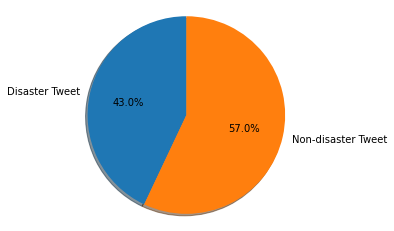

In [ ]:
# Check wehther we have class imbalance
is_disaster = round( sum(raw_train_set['target']==1)/len(raw_train_set), 4)
is_not_disaster = 1 - is_disaster

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Disaster Tweet', 'Non-disaster Tweet']
sizes = [is_disaster, is_not_disaster]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The data has a skew towards non-disaster tweet (57%). The magnitude is relative low so it should not significantly affect model performance. We can check in later stages whether we observe overfitting.

######**Disaster tweet**

In [ ]:
# Let's take a look of some non-disaster tweets
disaster = raw_train_set['text'][raw_train_set['target']==1]
disaster_sample = disaster.sample(n=10, random_state=1)

disaster_sample

617                Bioterrorism public health superbug biolabs epidemics biosurveillance outbreaks | Homeland Security News Wire http://t.co/cvhYGwcBZv
3801                                                                                     rgj: Truck trailer catches fire in Reno http://t.co/kAF3WdRmTn
3355                                                                 Good thing there was actually just a legit fire in the mall and nobody evacuated!!
2764    @Pam_Palmater i agree with @perrybellegarde to get out &amp; vote. Look at devastation @pmharper caused #FirstNations #IdleNoMore #cndpoli #yyj
2152              @HighQualityBird a reverse situation (lol I don't know 9/11?) where US civilian deaths were specifically utilized to make a political
2182                        #??? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...  http://t.co/zxCORQ0A3a
5049             @Doylech They're refugees: 'people who have been forced to leave their 

In [ ]:
raw_train_set[raw_train_set['id']==4882]

,id,keyword,location,text,target
3411,4882,explode,"Washington, D.C.",Kendall Jenner and Nick Jonas Are Dating and the World Might Quite Literally Explode http://t.co/pfvzVPxQGr,1


The majority of the sample tweets are accurate, but some are questionable. For example, tweet 3472 describes a concert and the provided URL points to a video of a concert. The sample is a mislabelled tweet in our opinion.

In addition, tweet with id 4882 has the following text, "Kendall Jenner and Nick Jonas Are Dating and the World Might Quite Literally Explode http://t.co/pfvzVPxQGr", this was labelled as a real disaster. Clearly, the example describes a piece of entertainment news, and the website points to an entertainment news platform. The instance has a faulty label according to the definition of disaster in the [oxford dictionary](https://www.lexico.com/definition/Disaster).


In [ ]:
raw_train_set[raw_train_set['id']==105]

,id,keyword,location,text,target
73,105,accident,Australia,BigRigRadio Live Accident Awareness,1


A more ambiguous example is tweet 105, "BigRigRadio Live Accident Awareness". Further research to this tweet shows "[BigRigRadio](https://twitter.com/bigrigradio?lang=en)" is a radio channel that reports accidents live in Australia. The organisation described in the tweet is associated with real disasters, but the body text is not describing a real natural disaster. The tweet is labelled positively, which is disputable, but since we do not have the full information on how tweets are labelled and this is an ambiguous case, no change will be made to this instance.  <br> <br>
In conclusion, the label quality of the dataset is questionable, and the definition of a "real" disaster tweet is unclear. However, since this dataset is widely used in the community and without significant issues raised from other users, we will deem it of satisfactory quality to use for the current analysis. In future analysis, we should create our own data-set to ensure high quality data. <br> <br>

###### **Non-disaster tweet**

In [ ]:
# Let's take a look of some non-disaster tweets
not_disaster = raw_train_set['text'][raw_train_set['target']==0]
not_disaster_sample = not_disaster.sample(n=10, random_state=1)

not_disaster_sample

2246              Businesses are deluged with invoices. Make yours stand out with colo r or shape and it's lzkely to rise to the top of the pay' pile.
7134              http://t.co/Ns1AgGFNxz #shoes Asics GT-II Super Red 2.0 11 Ronnie Fieg Kith Red White 3M x gel grey volcano 2 http://t.co/oD250zshFy
1290                                  @thomasvissman22 @KeithyyL Keithyy gettin burned outta the blocks and on social media.... http://t.co/dlkuFtLQnF
555           Kelby Tomlinson mild-mannered 2nd baseman for a great metropolitan team fights a never-ending battle for hits RBI and the #SFGiants way.
2700                                       Ignition Knock (Detonation) Sensor-Senso BECK/ARNLEY 158-1017 http://t.co/ryoByQJFCE http://t.co/LW9O2kDk18
4581                      @BuffoonMike I knew mo not doing much would bite us he was influenced by that shitty staff and injuries are not acquisitions
5123    Germany has  39 gigawatts of installed solar capacity\n_One gwatt is about equal to th

The random sample of non-disaster shows some tweets in the dataset are totally irrelevant to disaster, such as tweet 2246 and 5123. On the other hand, some problematic cases are tweets such as tweet 1290. we would have classified this as a disaster tweet if "on social media" was not in the tweet. It would be interesting in the implementation to see whether misclassified texts from the models are mainly composed of these tweets. 

###### **Text Cleaning**

After some reserach, it is unclear that whether BERT requires any extensive text cleaning before tokenisation. However, we remove components that provide no clear context for the classification such as website URL, emoji, html coding. The component that is not clear whether we should remove is punctuations. We will first remove these regardless. One area in later research is to investigate whether punctuations affect the performance of BERT significantly. We have left the task of lower casing because low-case BERT will do this automatically

In [ ]:
#Define functions to clean text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [ ]:
# Apply text cleaning functions
cleaned_train_set = raw_train_set.copy()
cleaned_test_set = raw_test_set.copy()

cleaned_train_set['text'] = cleaned_train_set['text'].apply(lambda x: remove_URL(x))
cleaned_train_set['text'] = cleaned_train_set['text'].apply(lambda x: remove_emoji(x))
cleaned_train_set['text'] = cleaned_train_set['text'].apply(lambda x: remove_html(x))

cleaned_test_set['text'] = cleaned_test_set['text'].apply(lambda x: remove_URL(x))
cleaned_test_set['text'] = cleaned_test_set['text'].apply(lambda x: remove_emoji(x))
cleaned_test_set['text'] = cleaned_test_set['text'].apply(lambda x: remove_html(x))

###### **Inspect Text Cleaning Results**

In [ ]:
# Inspect before clean
raw_random_sample = raw_train_set.sample(n=10, random_state=2)
raw_random_sample
#raw_train_set.head(10)

,id,keyword,location,text,target
3190,4579,emergency%20plan,North Hastings Ontario,Practice your families fire escape plan so everyone knows what to do in case of an emergency.,0
6171,8801,sirens,"Nomad, USA",Fuck Sleeping With Sirens.,0
1196,1722,buildings%20burning,NaN,'i'm a Gemini' *children screaming buildings burning police sirens in the distance*,1
680,982,blazing,"Pig Symbol, Alabama",Montgomery come for the blazing hot weather...stay for the STDs. Yet another rejected city slogan.,1
3358,4808,evacuated,NaN,I got evacuated from the cinema 30 mins through Inside Out\nKill me please,0
6432,9203,suicide%20bombing,NaN,&lt; 25 Dead In Kuwait Mosque Suicide Bombing Claimed By ISIS Offshoot on http://t.co/eTITgPSrUN,1
88,130,accident,"Manchester, NH",Accident left lane blocked in #Manchester on Rt 293 NB before Eddy Rd stop and go traffic back to NH-3A delay of 4 mins #traffic,1
291,426,apocalypse,San Francisco,@alexandrapullin It is indeed. If the apocalypse comes this week I know where I'll be :),0
6339,9061,structural%20failure,NaN,Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the coÛ_,1
4557,6478,injured,NaN,#golf McIlroy fuels PGA speculation after video: Injured world number one Rory McIlroy fueled speculatio... http://t.co/dCyYJVmXHR #news,0


In [ ]:
# Inspect after clean
cleaned_random_sample = cleaned_train_set.sample(n=10, random_state=2)
cleaned_random_sample

#cleaned_train_set.head(10)

,id,keyword,location,text,target
3190,4579,emergency%20plan,North Hastings Ontario,Practice your families fire escape plan so everyone knows what to do in case of an emergency.,0
6171,8801,sirens,"Nomad, USA",Fuck Sleeping With Sirens.,0
1196,1722,buildings%20burning,NaN,'i'm a Gemini' *children screaming buildings burning police sirens in the distance*,1
680,982,blazing,"Pig Symbol, Alabama",Montgomery come for the blazing hot weather...stay for the STDs. Yet another rejected city slogan.,1
3358,4808,evacuated,NaN,I got evacuated from the cinema 30 mins through Inside Out\nKill me please,0
6432,9203,suicide%20bombing,NaN,25 Dead In Kuwait Mosque Suicide Bombing Claimed By ISIS Offshoot on,1
88,130,accident,"Manchester, NH",Accident left lane blocked in #Manchester on Rt 293 NB before Eddy Rd stop and go traffic back to NH-3A delay of 4 mins #traffic,1
291,426,apocalypse,San Francisco,@alexandrapullin It is indeed. If the apocalypse comes this week I know where I'll be :),0
6339,9061,structural%20failure,NaN,Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the coÛ_,1
4557,6478,injured,NaN,#golf McIlroy fuels PGA speculation after video: Injured world number one Rory McIlroy fueled speculatio... #news,0


It looks like our functions successfully removed URLs. We decided to keep punctuations such as hashtags (#), at symbol (@) as we were unable to find literature to support removing them when using BERT. Moreover, for human interpretation, these punctuations do offer contextual value. For example, @alexandrapullin in tweet ID 426 tells us it refers to an account with that name. It reaffirms the sentence is referring to a person or an entity. With hashtags (#), they serve as a summary word in a tweet which should also offer contextual value for the model. 
Furthermore, BERT's tokenisation would separate the hashtag with the word following it if that are in it's dictionary. For example, #golf in the last tweet displayed would be isolated to "#" and "golf".  These punctuations should not materially affect the inputs to BERT.

###### **Tweet length**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


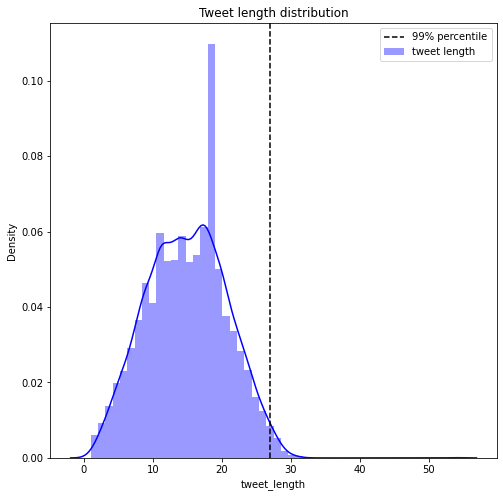

Average Tweet word count: 15.0
99%tile word count: 27


In [ ]:
# Check tweets length (Disaster & Non-disaster)
cleaned_train_set['tweet_length'] = cleaned_train_set['text'].apply(lambda words: len(words.split(" ")))
#max_seq_len = np.round(cleaned_train_set['tweet_length'].mean() + cleaned_train_set['tweet_length'].std()).astype(int)
percentile_seq_len = np.percentile(cleaned_train_set['tweet_length'],99).astype(int)

plt.figure(figsize=(8,8))
sns.distplot(cleaned_train_set['tweet_length'], hist=True, kde=True, color='b', label='tweet length')
plt.axvline(x=percentile_seq_len, color='k', linestyle='--', label='99% percentile')
plt.title('Tweet length distribution'); plt.legend()
plt.show()
print('Average Tweet word count:',np.round(cleaned_train_set['tweet_length'].mean()))
print('99%tile word count:',percentile_seq_len)

Average tweet length is 15 words and the 99th percentile is 27 words. This should be lower than our default threshold of 128 even after unknown word split.

##### **Summary of other not-used attributes**

Feature: *Location*, *Key Word* <br>
The feature *location* have significant missing values (33.3%), it also has very high cardinality (3341 unique values) compare to the number of instances (7613). At a closer look, values do not share the same granularity. For example, there are values for cities ("Birmingham"), for the whole continent ("AFRICA") and the same country is repeated with different variation ("USA", "United States"). <br><br> Since the analysis objective is to use BERT to analyse the text and classify tweet, we should not investigate and clean the data further. However, one hypothesise arrives with this is - does having a location tag makes a tweet more likely to be real? This is a question to be answered in a separate study.




## 6 Implementation & Experimentation

In this section of the analysis we will fine-tune a version of BERT from the tensorflow library to correctly classify disaster tweet. We will experiment with different hyperparamter choices. Moreover, we will explore BERT's performance under different scenarios to build a deep understanding of BERT's limitations. The implementation and experimenetation steps are summarised below:

*   BERT finetuning and hyper-parameter selection from recommended range
*   Implement a pretrained FastText embedding with bi-LSTM layer(s) for comparison
*   Performance comparison
*   Performnace investigation<br> (1)Classifying tweets with contraction expansions,<br> (2) Classifying tweets with misspelled words



### **BERT Implementation**

###### **BERT version selection, Defining model**

In [ ]:
##@title Choose a BERT model to fine-tune { display-mode: "form" }

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


We have selected the uncased base BERT model to explore. The model has 12 layers (L-12), 768 hidden features (H-768) for a single word embedding and 12 attention heads (A-12). In the original paper, the researchers made the base model so that they can compare it with OpenAI GPT model.<br> <br>
In addition, the authors concluded extreme model size also leads to large performance improvement in small scale task. However, due to time and resources constraint of this project, we shall limit to the base bert model for fast experimentations. 



In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

###### **Model Summary**

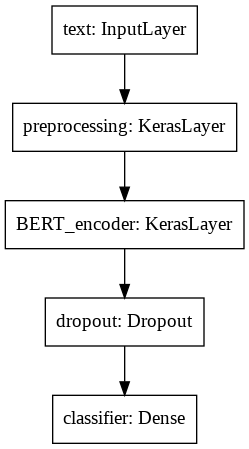

In [ ]:
# High level model summary
classifier_model_example = build_classifier_model()
tf.keras.utils.plot_model(classifier_model_example)

###### **Pre-processing Explained**

An input text has to be pre-processed to a format that BERT can understand. Different words/letters are represented as a numeric token in BERT. We will run a short text here to demonstrate.

In [ ]:
# Define preprocessing model for demo
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['LSE Deep Learning Class']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1048 3366 2784 4083 2465  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see from above, the shape of the output is (1,128). Maximum input token number to BERT is 512 but the default package limit is 128 hence the output dimension. The word ids represent the token ids of the inputted words. Token 101 represents the beginning of the input and token 102 represents the end or a sentence break. <br> <br>
Excluding token 101 and 102, you will find there are five tokens but our input sentence has four words. This demonstrates how BERT handle words that are not in it's current vocabulary. The word "LSE" has separated to components that exist in the BERT's pre-trained vocabulary. This is shown from later code snippet below. The "L" has a token representation of 1048 and therefore "SE" must be represented by 3366. <br> <br>
Input mask is used to differentiate between actual inputs and padding. There is padding because each input must have the same fixed length. 1 represents actual input, 0 represents padding. <br> <br>
Type ids only one value of 0 here because this is a single sentence input. For multiple sentence input, it has one number for each input.

In [ ]:
text_test = ['lse deep learning class']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1048 3366 2784 4083 2465  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As shown by the above example, because we are using an uncased version of BERT, upper and lower case words are treated the same. 

In [ ]:
text_test = ['LSE']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

Word Ids   : [ 101 1048 3366  102    0    0    0    0    0    0    0    0]


In [ ]:
text_test = ['L']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

Word Ids   : [ 101 1048  102    0    0    0    0    0    0    0    0    0]


The above demonstrate the word LSE is split to L and SE when being pre-processed.

###### **Hyper-parameter tuning**
Training and keeping 6 different models will exhaust allocated resources from Google Colab. Therefore, models are trained one at a time, information on loss/ accuracy is store for comparison later.

Similarly, we are using adam optimiser here as the original paper suggested. It is also recommended that we should experiment with other model variables:

*   Batch size: (1) 16, (2) 32
*   Learning rate: (a) 5e-5, (b) 3e-5, (c) 2e-5
*   Number of epochs: 2, 3, 4

We are expecting some sensitivity towards the hyperparamter choices as the researchers have pointed out they observe stability with 100k+ label training examples but here we have far less data for disaster tweet task. We will run experiments with the different batch size, learning rate choices using 4 epochs. We can pick the best performing number of epochs after the experiments.



In [ ]:
#Train/validation set split (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_train_set['text'].tolist(),\
                                                      cleaned_train_set['target'].tolist(),\
                                                      test_size=0.20,\
                                                      stratify = cleaned_train_set['target'].tolist(),\
                                                      random_state=0) #Keeping the same split for all experimentations

In [ ]:
batch_size_1 = 32
batch_size_2 = 16

seed = 1

train_ds_32 = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size_1)
valid_ds_32 = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(batch_size_1)

train_ds_16 = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size_2)
valid_ds_16 = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(batch_size_2)

In [ ]:
# Fine-tuning loops
# Limited resources when training on google colab, cannot maintain 6 different
# models hence we will train it individually and record results 

history_dict = {}

epochs = 4

steps_per_epoch = [tf.data.experimental.cardinality(train_ds_16).numpy(),
                   tf.data.experimental.cardinality(train_ds_32).numpy()]

num_train_steps = [steps_per_epoch[0]*epochs,
                   steps_per_epoch[1]*epochs]

num_warmup_steps = [int(0.1*num_train_steps[0]),
                    int(0.1*num_train_steps[1])]

init_lr = [5e-5,3e-5,2e-5]

for i in range(len(steps_per_epoch)):
  
  if i == 0:
    train = train_ds_16
    valid = valid_ds_16
  else:
    train = train_ds_32
    valid = valid_ds_32

  for j in range(len(init_lr)):
    classifier_model = build_classifier_model()
    
    optimizer = optimization.create_optimizer(init_lr=init_lr[j],
                                          num_train_steps = num_train_steps[i],
                                          num_warmup_steps = num_warmup_steps[i],
                                          optimizer_type = 'adamw')

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
    


    print(f'Training model with {tfhub_handle_encoder}, Batch-size: {(i+1)*16}, Learning rate: {init_lr[j]}')
    history = classifier_model.fit(x=train, validation_data=valid, epochs=epochs)
    
    key = str((i+1)*16) + "-" + str(j+1)

    history_dict[key] = history.history

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3, Batch-size: 16, Learning rate: 5e-05
Epoch 1/4
381/381 [==============================] - 96s 200ms/step - loss: 0.5421 - binary_accuracy: 0.7190 - recall_m: 0.4528 - precision_m: 0.7084 - f1_m: 0.5176 - val_loss: 0.4097 - val_binary_accuracy: 0.8267 - val_recall_m: 0.6685 - val_precision_m: 0.8964 - val_f1_m: 0.7503
Epoch 2/4
381/381 [==============================] - 75s 197ms/step - loss: 0.3655 - binary_accuracy: 0.8567 - recall_m: 0.7535 - precision_m: 0.8999 - f1_m: 0.8059 - val_loss: 0.5434 - val_binary_accuracy: 0.8293 - val_recall_m: 0.7705 - val_precision_m: 0.8314 - val_f1_m: 0.7859
Epoch 3/4
381/381 [==============================] - 75s 197ms/step - loss: 0.2548 - binary_accuracy: 0.9106 - recall_m: 0.8430 - precision_m: 0.9399 - f1_m: 0.8797 - val_loss: 0.6377 - val_binary_accuracy: 0.8253 - val_recall_m: 0.7509 - val_precision_m: 0.8321 - val_f1_m: 0.7733
Epoch 4/4
381/381 [==============

In [ ]:
# We tested the combinations of 
print(history_dict.keys())

dict_keys(['16-1', '16-2', '16-3', '32-1', '32-2', '32-3'])


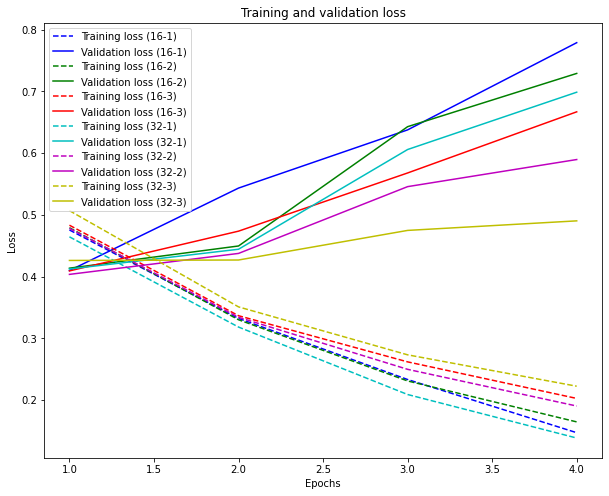

In [ ]:
# Plot Losses
num_epochs = range(1, epochs+1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()
i = 0
colors = ['b','g','r','c','m','y']

#plt.subplot(2, 1, 1)
for key in history_dict.keys():
  loss = history_dict[key]['loss']
  val_loss = history_dict[key]['val_loss']
  plt.plot(num_epochs, loss, '--', label= f'Training loss ({key})', color = colors[i] )
  plt.plot(num_epochs, val_loss, '-', label= f'Validation loss ({key})', color = colors[i]  )
  i += 1

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

###### **Observations from training and validation loss**
In general, loss is decreasing with the training set but increasing for the validation set, under the different combinations of batch size and learning rate. This observation suggests overfitting. We should see if the overfitting significantly affects the accuracy and F1 score in the charts for accuracy and F1 score.

The reason for overfitting might be due to our small dataset. We only have 7613 instances for training and validation. In general, with a large model like BERT, there are enough parameters to "memorise" the small dataset and hence overfitting easily occurs. In another analysis, we should increase the dataset size and see if this observation reoccurs. <br>

Observing the results across different learning rate settings, in particular with the validation losses, it appears the model overfits more with higher learning rate settings. These results coincide with Sun et al. as they investigate the Catastrophic Forgetting problem [2]. <br>

Also, a larger batch size looks to overfit less. This observation is consistent with other discussions in the wider [non-academic community](https://www.reddit.com/r/LanguageTechnology/comments/c8j7pd/share_your_transformerbertgpt2_training_tips/).

As our primary evaluation metric is the F1 score, we should select a model later when evaluating the results against the F1 score. However, the preliminary best candidate model appears to be the model with batch size 32 and learning rate 2e-2. It exhibits the lowest increase in validation loss as training loss decreases.

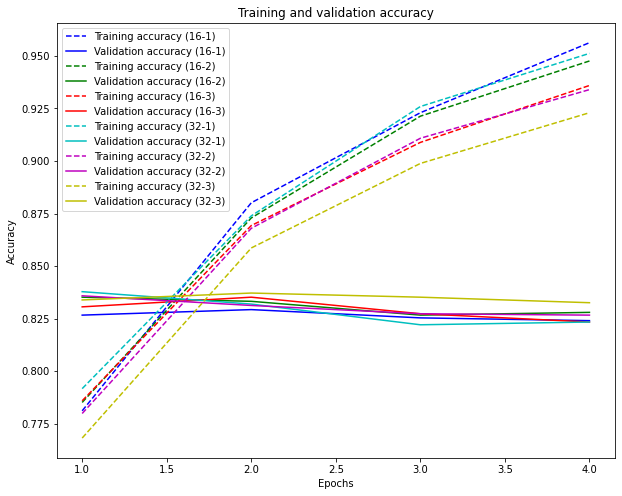

In [ ]:
# Plot Accuracy
fig = plt.figure(figsize=(10, 8))
i = 0

for key in history_dict.keys():
  acc = history_dict[key]['binary_accuracy']
  val_acc = history_dict[key]['val_binary_accuracy']
  plt.plot(num_epochs, acc, '--', label= f'Training accuracy ({key})', color = colors[i] )
  plt.plot(num_epochs, val_acc, '-', label= f'Validation accuracy ({key})', color = colors[i]  )
  i += 1

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

######**Accuracy**
The accuracy plot reinforces the overfitting story. Training accuracy improves significantly across epochs but validation accuracy remains at similar level. <br><br>
The validation accuracy across all the different hyperparameter settings are very similar though, which contradicts the hyperparamter sensitivity associated with small datasets mentioned in the original paper. However, the authors did not clearly discuss the size of a small dataset. Further investigation is needed for this contradiction.<br><br> In future analysis, we can reduce the current training set size in a step-wise fashion to investigate what data-set size provides for stable performances.



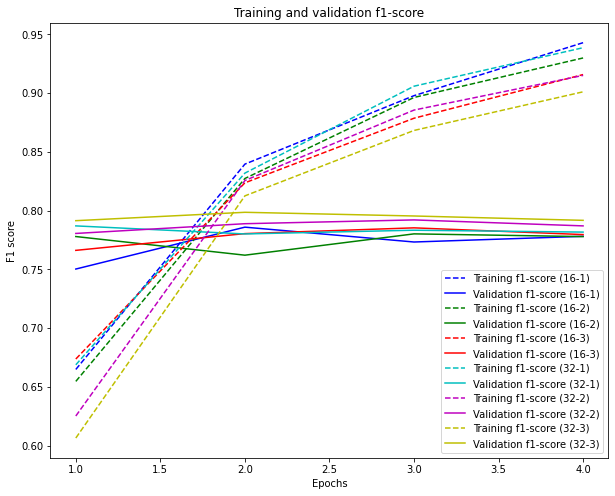

In [ ]:
# Plot F1
fig = plt.figure(figsize=(10, 8))
i = 0

for key in history_dict.keys():
  f1 = history_dict[key]['f1_m']
  val_f1 = history_dict[key]['val_f1_m']
  plt.plot(num_epochs, f1, '--', label= f'Training f1-score ({key})', color = colors[i] )
  plt.plot(num_epochs, val_f1, '-', label= f'Validation f1-score ({key})', color = colors[i]  )
  i += 1

plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()

######**F1-score**
The training F1 score rapidly increases across different epochs, meanwhile the validation F1 score generally increases slowly but starts to decrease as we approach the 4th epoch. As our selection metric is the F1-score, we will select the model with batch size 32, learning rate 2e-5 as the final candidate model and train it up to 2 epochs. This model has the highest validation F1 score <br> <br>

Before we conclude with this model, we want to try increasing the dropout parameter and see if this will reduce the overfitting.

###### **Reduce overfit by increasing dropout**
One method to prevent overfitting is to add dropout layers to the network. A Dropout layer randomly sets a proportion of its input units to 0 for each training example. This forces the network not to over-rely on some particular nodes and it has been shown that it is an effective regularisation technique. All nodes are active during validation/ inference step. <br> <br>

In the original BERT paper, all experiments were conducted with 10% dropout and no experimentation for dropout values was mentioned. Hence, we will first increase the percentage of dropout after the encoder output from 10% to 30% to see if this might reduce the overfitting.

In [ ]:
def build_classifier_model_2():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
n_epoch = 4

steps_per_epoch = tf.data.experimental.cardinality(train_ds_32).numpy()

num_train_steps = steps_per_epoch*n_epoch

num_warmup_steps = int(0.1*num_train_steps)



In [ ]:
classifier_model = build_classifier_model_2()
    
optimizer = optimization.create_optimizer(init_lr=2e-5,
                                          num_train_steps = num_train_steps,
                                          num_warmup_steps = num_warmup_steps,
                                          optimizer_type = 'adamw')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)



print(f'Training model with {tfhub_handle_encoder}, Batch-size: {32}, Learning rate: {2e-5}')
history = classifier_model.fit(x=train_ds_32, validation_data=valid_ds_32, epochs=n_epoch)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3, Batch-size: 32, Learning rate: 2e-05
Epoch 1/4
191/191 [==============================] - 94s 378ms/step - loss: 0.6951 - binary_accuracy: 0.7170 - recall_m: 0.6501 - precision_m: 0.5882 - f1_m: 0.5834 - val_loss: 0.4027 - val_binary_accuracy: 0.8326 - val_recall_m: 0.7541 - val_precision_m: 0.8348 - val_f1_m: 0.7856
Epoch 2/4
191/191 [==============================] - 71s 373ms/step - loss: 0.3921 - binary_accuracy: 0.8379 - recall_m: 0.7523 - precision_m: 0.8582 - f1_m: 0.7960 - val_loss: 0.4205 - val_binary_accuracy: 0.8332 - val_recall_m: 0.7661 - val_precision_m: 0.8294 - val_f1_m: 0.7911
Epoch 3/4
191/191 [==============================] - 71s 372ms/step - loss: 0.3151 - binary_accuracy: 0.8808 - recall_m: 0.8075 - precision_m: 0.9086 - f1_m: 0.8492 - val_loss: 0.4781 - val_binary_accuracy: 0.8240 - val_recall_m: 0.7861 - val_precision_m: 0.7970 - val_f1_m: 0.7866
Epoch 4/4
191/191 [==============

 Model Performance (Increase dropout after encoder output)


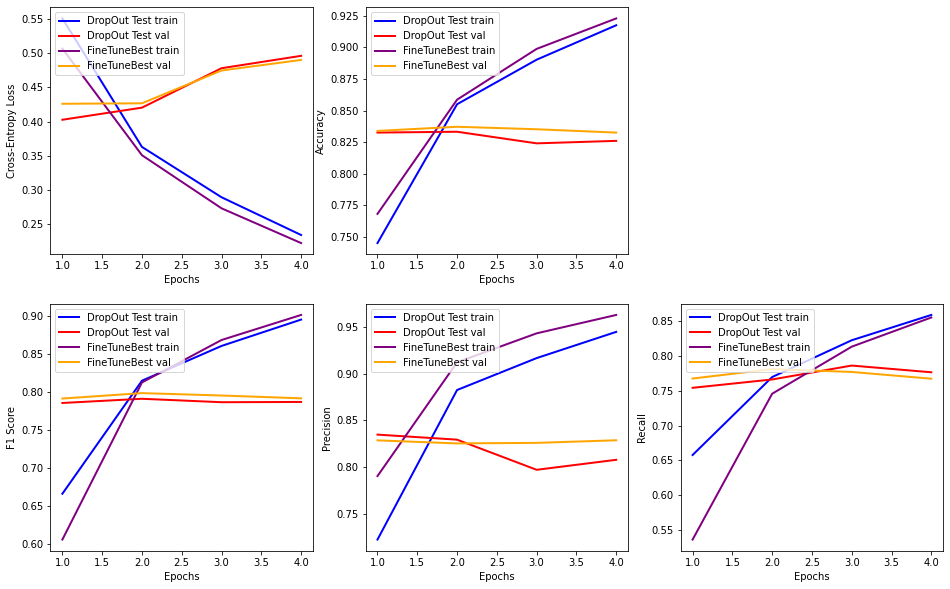

In [ ]:
#generate plots
print(' Model Performance (Increase dropout after encoder output)')
compare_models(history, history_dict['32-3'], 'DropOut Test', 'FineTuneBest')


The experiment results actually show some loss in performance after increasing the dropout. Moreover, precision were less stable across the epochs. Therefore, we will not implement the increase in dropout for our final BERT model. <br> <br> However, the reader should note we have only increased the parameter of the dropout layer which comes after the top encoder output for our quick experiment. In future analysis, we should experiment with the parameters of dropout layers within the encoders of BERT. However, due to time constraint of this analysis, we will leave this further experiment for another analysis. The reader may refer to this [tutorial](https://www.tensorflow.org/official_models/fine_tuning_bert) for defining parameters within the encoder layers of BERT.

###### **Final BERT model**
Batch Size: 32 <br>
Initial Learning Rate: 2e-5 <br>
Epochs: 2 <br>

We train our final model specifically, for comparison with the FastText-LSTM model later.



In [ ]:
# Initialise the data-set
seed = 1

train_ds_32 = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
valid_ds_32 = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(32)

# Model settings
n_epoch = 2

steps_per_epoch = tf.data.experimental.cardinality(train_ds_32).numpy()

num_train_steps = steps_per_epoch*n_epoch

num_warmup_steps = int(0.1*num_train_steps)

In [ ]:
BERT_classifier_model = build_classifier_model()
    
optimizer = optimization.create_optimizer(init_lr=2e-5,
                                          num_train_steps = num_train_steps,
                                          num_warmup_steps = num_warmup_steps,
                                          optimizer_type = 'adamw')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

BERT_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
    
print(f'Training model with {tfhub_handle_encoder}, Batch-size: {32}, Learning rate: {2e-5}')
BERT_history = BERT_classifier_model.fit(x=train_ds_32, validation_data=valid_ds_32, epochs=2)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3, Batch-size: 32, Learning rate: 2e-05
Epoch 1/2
191/191 [==============================] - 126s 585ms/step - loss: 0.5865 - binary_accuracy: 0.6958 - recall_m: 0.4080 - precision_m: 0.6393 - f1_m: 0.4756 - val_loss: 0.4222 - val_binary_accuracy: 0.8359 - val_recall_m: 0.7637 - val_precision_m: 0.8381 - val_f1_m: 0.7932
Epoch 2/2
191/191 [==============================] - 111s 580ms/step - loss: 0.3649 - binary_accuracy: 0.8507 - recall_m: 0.7311 - precision_m: 0.9067 - f1_m: 0.8030 - val_loss: 0.4145 - val_binary_accuracy: 0.8385 - val_recall_m: 0.7255 - val_precision_m: 0.8751 - val_f1_m: 0.7863


BERT Final Model


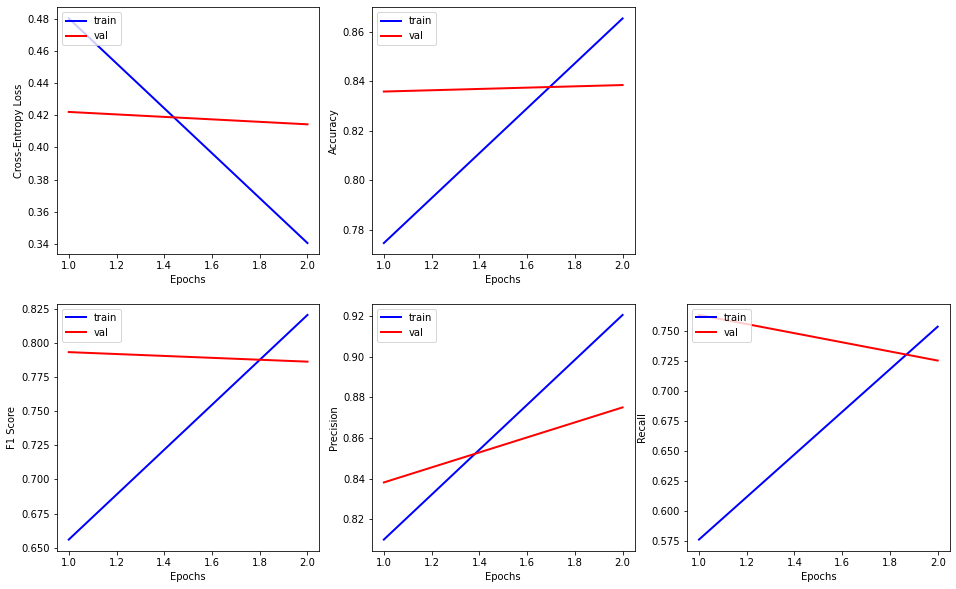

Final training loss:0.34, Final validation loss:0.41
Final training F1-score:82.0%, Final validation F1-score:79.0%
Final training accuracy:87.0%, Final validation accuracy:84.0%


In [ ]:
#generate plots
print('BERT Final Model')
plot_training(BERT_history)
final_epoch_performance(BERT_history)

Similar results as observed in our hyperparameter tuning, the final F1-score at 79%

### LSTM with pre-trained fastText embeddings Implementation

###### **Package downloads, set-up**

In [ ]:
# Download the FastTest pre-trained embeddings (English Version)
import requests, zipfile, io

r = requests.get("https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
# Import necessary packages

#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs

# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

#sns.set_style("whitegrid")

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# load word embeddings

print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1030it [00:00, 10297.51it/s]

loading word embeddings...


999995it [02:02, 8155.76it/s]

found 999995 word vectors


###### **Tokenisation and mapping word embeddings**
Unlike BERT, the FastText-LSTM implementation is more bespoke hence we need to tokenise the words and also map the word embeddings/vector ourselves. The distinction between word token and word embedding is that the token is a look-up key for the word embedding values. The word embedding values represent the model's understanding of words and how each words associate with other words. A detailed graphical explanation can be found [here](https://stackoverflow.com/questions/50184280/how-to-conceptually-think-about-relationship-between-tokenized-words-and-word-em).

In [ ]:
raw_docs_train = cleaned_train_set['text'].tolist()
raw_docs_test = cleaned_test_set['text'].tolist() 

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=percentile_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=percentile_seq_len)

  6%|▌         | 456/7613 [00:00<00:01, 4555.17it/s]

pre-processing train data...


100%|██████████| 3263/3263 [00:00<00:00, 4583.17it/s]


tokenizing input data...
dictionary size:  22164


In [ ]:
# Traning parameters are referenced to this non-academic article: 
# https://towardsdatascience.com/text-classification-on-disaster-tweets-with-lstm-and-word-embedding-df35f039c1db

#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#embedding matrix
print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 7704


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['uk\x89ûªs' 'allergan' 'rrbc' 'envw98' 'modcloth' '9newsbrisbane'
 'anthonyshead' 'breh' 'stoponesounds' 'dalinthanelan']


A random sample of words not in the existing vocabulary show they are mostly random meaningless words and also words with misspellings. We will just zero them for their word vectors.

The below architecture was inspired by this [article](https://towardsdatascience.com/text-classification-on-disaster-tweets-with-lstm-and-word-embedding-df35f039c1db). We will further expand on this architecture to find a higher performing architecture.

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=percentile_seq_len, weights=[embedding_matrix],trainable=False, name = 'FastText'))
model.add(Bidirectional(LSTM(64,return_sequences= False), name = 'Bi-LSTM'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1, name = 'Dropout'))

model.add(Dense(1,activation='sigmoid', name = 'Classifier_layer'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FastText (Embedding)         (None, 27, 300)           6649500   
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 128)               186880    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
Dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Classifier_layer (Dense)     (None, 1)                 33        
Total params: 6,840,541
Trainable params: 191,041
Non-trainable params: 6,649,500
_________________________________________________________________


In [ ]:
#Train/validation set split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(word_seq_train.tolist(),\
                                                      cleaned_train_set['target'].tolist(),\
                                                      test_size=0.20,\
                                                      stratify = cleaned_train_set['target'].tolist(),\
                                                      random_state=0)

train_ds_256 = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(256)
valid_ds_256 = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(256)

In [ ]:
# Compile models

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics)

In [ ]:
FT_history = model.fit(x=train_ds_256,validation_data=valid_ds_256,epochs=num_epochs)

Epoch 1/40
24/24 [==============================] - 4s 44ms/step - loss: 0.6589 - binary_accuracy: 0.6026 - recall_m: 0.3046 - precision_m: 0.6032 - f1_m: 0.3185 - val_loss: 0.4852 - val_binary_accuracy: 0.7965 - val_recall_m: 0.7515 - val_precision_m: 0.7694 - val_f1_m: 0.7599
Epoch 2/40
24/24 [==============================] - 0s 13ms/step - loss: 0.4843 - binary_accuracy: 0.7858 - recall_m: 0.7234 - precision_m: 0.7766 - f1_m: 0.7442 - val_loss: 0.4252 - val_binary_accuracy: 0.8207 - val_recall_m: 0.7166 - val_precision_m: 0.8445 - val_f1_m: 0.7739
Epoch 3/40
24/24 [==============================] - 0s 13ms/step - loss: 0.4321 - binary_accuracy: 0.8170 - recall_m: 0.7412 - precision_m: 0.8222 - f1_m: 0.7767 - val_loss: 0.4162 - val_binary_accuracy: 0.8240 - val_recall_m: 0.7104 - val_precision_m: 0.8569 - val_f1_m: 0.7759
Epoch 4/40
24/24 [==============================] - 0s 12ms/step - loss: 0.4162 - binary_accuracy: 0.8242 - recall_m: 0.7411 - precision_m: 0.8377 - f1_m: 0.7836 -

Initial FastText-LSTM Model Performance


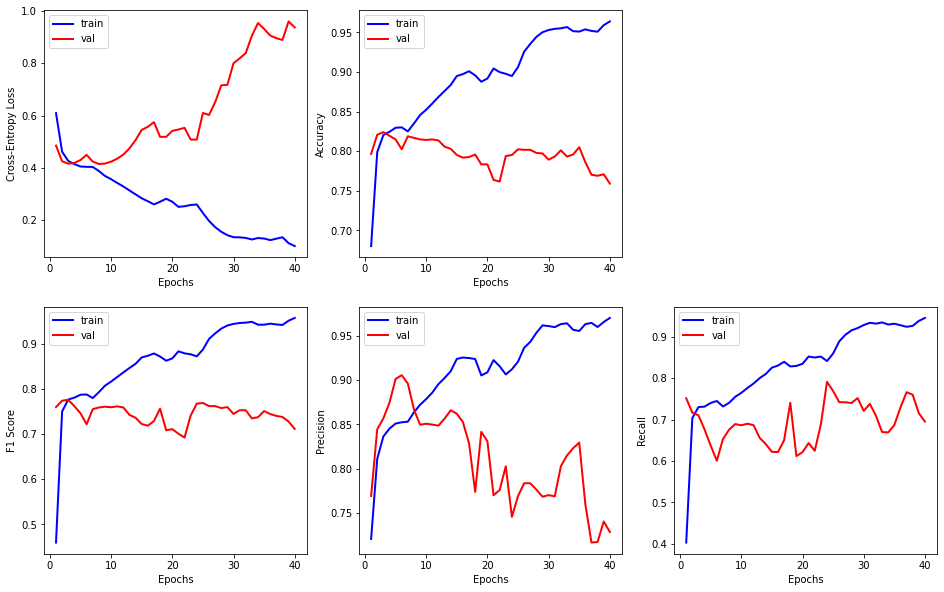

Final training loss:0.1, Final validation loss:0.94
Final training F1-score:96.0%, Final validation F1-score:71.0%
Final training accuracy:96.0%, Final validation accuracy:76.0%


In [ ]:
#generate plots
print('Initial FastText-LSTM Model Performance')
plot_training(FT_history)
final_epoch_performance(FT_history)

The graphs show a clear case of overfitting, training loss continues to decrease while validation loss increases rapidly. The F1 socre is more resilient, it mostly hovers around the 75% mark, with some decreases over the different epochs. We should increase dropout and also introduce early stopping for decreasing the overfitting.

######**Increase dropout, add dropout layer, add early stopping**
Increase dropout percentage to 30% and also add another dropout layer after the embedding layer

In [ ]:
#Should apply early stopping and add more dropout
model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=percentile_seq_len, weights=[embedding_matrix],trainable=False, name = 'FastText'))
model.add(Dropout(0.3, name = 'Dropout_1'))
model.add(Bidirectional(LSTM(64,return_sequences= False), name = 'Bi-LSTM'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3, name = 'Dropout_2'))
model.add(Dense(1,activation='sigmoid', name = 'Classifier_layer'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FastText (Embedding)         (None, 27, 300)           6649500   
_________________________________________________________________
Dropout_1 (Dropout)          (None, 27, 300)           0         
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 128)               186880    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
Dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
Classifier_layer (Dense)     (None, 1)                 33        
Total params: 6,840,541
Trainable params: 191,041
Non-trainable params: 6,649,500
______________________________________

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics)

es_callback = EarlyStopping(monitor='val_loss', patience=3)

FT_history_2 = model.fit(x=train_ds_256,validation_data=valid_ds_256,epochs=num_epochs, callbacks=[es_callback])

Epoch 1/40
24/24 [==============================] - 4s 44ms/step - loss: 0.6750 - binary_accuracy: 0.6443 - recall_m: 0.1511 - precision_m: 0.3871 - f1_m: 0.1813 - val_loss: 0.5175 - val_binary_accuracy: 0.7768 - val_recall_m: 0.6678 - val_precision_m: 0.7822 - val_f1_m: 0.7192
Epoch 2/40
24/24 [==============================] - 0s 12ms/step - loss: 0.5307 - binary_accuracy: 0.7626 - recall_m: 0.7118 - precision_m: 0.7436 - f1_m: 0.7200 - val_loss: 0.4417 - val_binary_accuracy: 0.8024 - val_recall_m: 0.6553 - val_precision_m: 0.8495 - val_f1_m: 0.7388
Epoch 3/40
24/24 [==============================] - 0s 13ms/step - loss: 0.4676 - binary_accuracy: 0.7920 - recall_m: 0.6829 - precision_m: 0.8101 - f1_m: 0.7387 - val_loss: 0.4332 - val_binary_accuracy: 0.8155 - val_recall_m: 0.6525 - val_precision_m: 0.8865 - val_f1_m: 0.7508
Epoch 4/40
24/24 [==============================] - 0s 13ms/step - loss: 0.4433 - binary_accuracy: 0.8084 - recall_m: 0.6995 - precision_m: 0.8362 - f1_m: 0.7577 -

2nd Experiment Performance (Added drop-out)


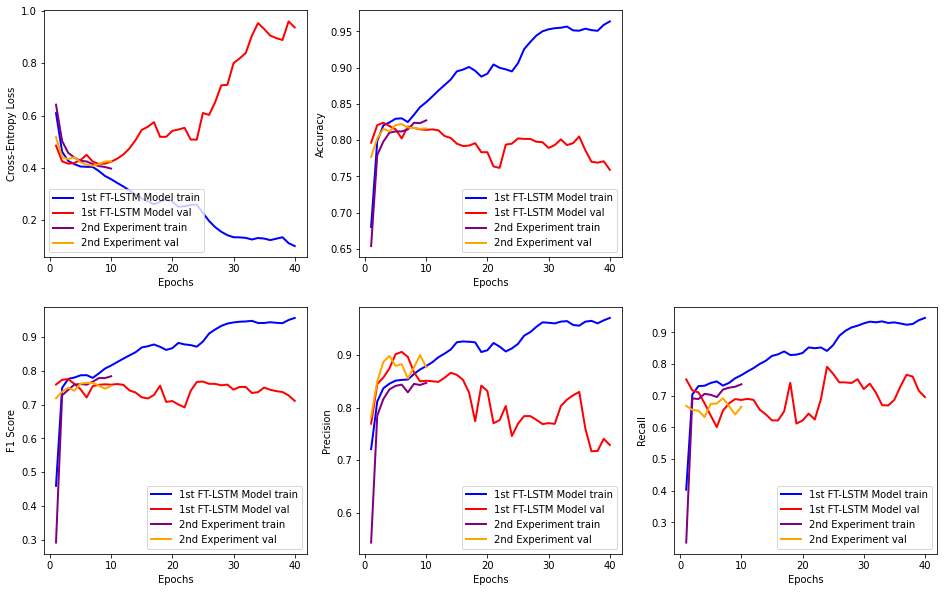

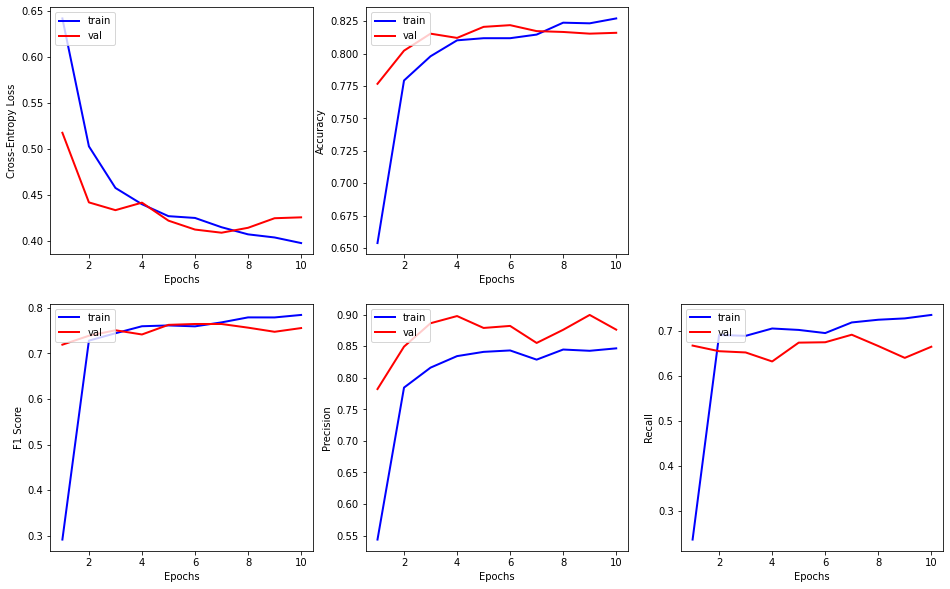

In [ ]:
#generate plots
print('2nd Experiment Performance (Added drop-out)')
compare_models_FT(FT_history,FT_history_2,'1st FT-LSTM Model','2nd Experiment','lower left','lower right','lower right','lower right','lower right')
plot_training(FT_history_2)
#final_epoch_performance(history)

Early stopping and increasing dropout are moderately effective. Both training and validation loss are slightly lower than our previous model losses. Furthermore, early stopping clearly prevent the validation F1-score to decrease from training with more epochs.

######**Does adding more LSTM layers increase performance?**

In [ ]:
model = tf.keras.Sequential(name= '3rd_Experiment')
model.add(Embedding(nb_words,embed_dim,input_length=percentile_seq_len, weights=[embedding_matrix],trainable=False, name = 'FastText'))
model.add(Dropout(0.3, name = 'Dropout_1'))
model.add(Bidirectional(LSTM(64,return_sequences= True), name = 'Bi-LSTM_1'))
model.add(Bidirectional(LSTM(64,return_sequences= True), name = 'Bi-LSTM_2'))
model.add(Bidirectional(LSTM(64,return_sequences= True), name = 'Bi-LSTM_3'))
model.add(Bidirectional(LSTM(64,return_sequences= False), name = 'Bi-LSTM_4'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3, name = 'Dropout_2'))
model.add(Dense(1,activation='sigmoid', name = 'Classifier_layer'))
model.summary()

Model: "3rd_Experiment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FastText (Embedding)         (None, 27, 300)           6649500   
_________________________________________________________________
Dropout_1 (Dropout)          (None, 27, 300)           0         
_________________________________________________________________
Bi-LSTM_1 (Bidirectional)    (None, 27, 128)           186880    
_________________________________________________________________
Bi-LSTM_2 (Bidirectional)    (None, 27, 128)           98816     
_________________________________________________________________
Bi-LSTM_3 (Bidirectional)    (None, 27, 128)           98816     
_________________________________________________________________
Bi-LSTM_4 (Bidirectional)    (None, 128)               98816     
_________________________________________________________________
dense_13 (Dense)             (None, 32)             

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics)

es_callback = EarlyStopping(monitor='val_loss', patience=3)

FT_history_3 = model.fit(x=train_ds_256,validation_data=valid_ds_256,epochs=num_epochs, callbacks=[es_callback])

Epoch 1/40
24/24 [==============================] - 13s 129ms/step - loss: 0.6449 - binary_accuracy: 0.7009 - recall_m: 0.2709 - precision_m: 0.4280 - f1_m: 0.3053 - val_loss: 0.4762 - val_binary_accuracy: 0.7899 - val_recall_m: 0.5967 - val_precision_m: 0.8732 - val_f1_m: 0.7082
Epoch 2/40
24/24 [==============================] - 1s 30ms/step - loss: 0.4768 - binary_accuracy: 0.7888 - recall_m: 0.6874 - precision_m: 0.8057 - f1_m: 0.7358 - val_loss: 0.4435 - val_binary_accuracy: 0.8109 - val_recall_m: 0.6453 - val_precision_m: 0.8816 - val_f1_m: 0.7443
Epoch 3/40
24/24 [==============================] - 1s 31ms/step - loss: 0.4540 - binary_accuracy: 0.8002 - recall_m: 0.6852 - precision_m: 0.8287 - f1_m: 0.7458 - val_loss: 0.4177 - val_binary_accuracy: 0.8188 - val_recall_m: 0.7267 - val_precision_m: 0.8305 - val_f1_m: 0.7743
Epoch 4/40
24/24 [==============================] - 1s 31ms/step - loss: 0.4271 - binary_accuracy: 0.8142 - recall_m: 0.7412 - precision_m: 0.8149 - f1_m: 0.7751

3rd Experiment Performance (Add more LSTM layers)


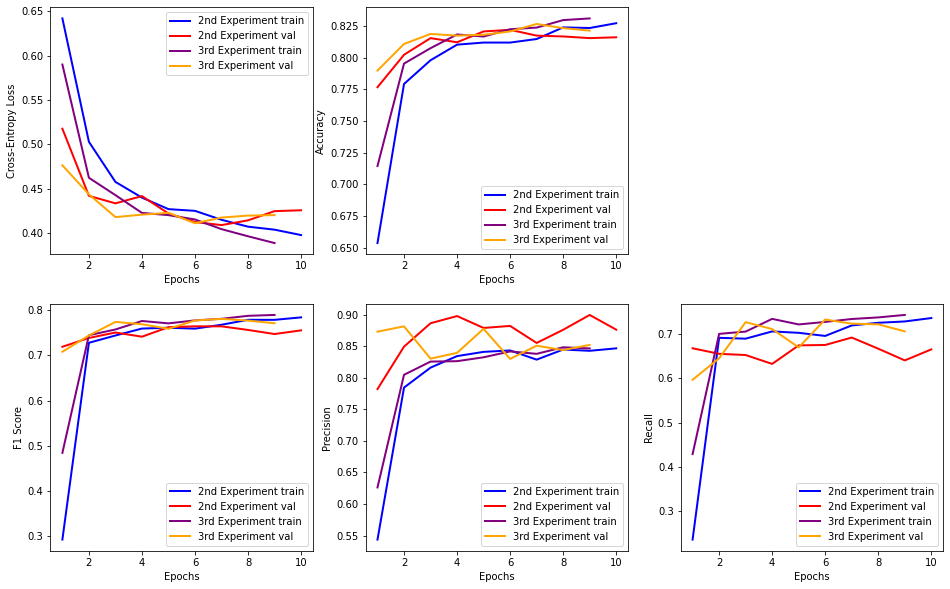

2nd FT-LSTM Experiment
Final training loss:0.4, Final validation loss:0.43
Final training F1-score:78.0%, Final validation F1-score:76.0%
Final training accuracy:83.0%, Final validation accuracy:82.0%


3rd FT-LSTM Experiment
Final training loss:0.39, Final validation loss:0.42
Final training F1-score:79.0%, Final validation F1-score:77.0%
Final training accuracy:83.0%, Final validation accuracy:82.0%


In [ ]:
#generate plots
print('3rd Experiment Performance (Add more LSTM layers)')
compare_models_FT(FT_history_2,FT_history_3,'2nd Experiment','3rd Experiment',
                  'upper right','lower right','lower right','lower right','lower right')

print('2nd FT-LSTM Experiment')
final_epoch_performance(FT_history_2)
print('\n')
print('3rd FT-LSTM Experiment')
final_epoch_performance(FT_history_3)

Adding more LSTM layers did  help to improve the performance of the model by 1% in F1-score and reduce both training and validation loss but this is not hugely significant. We prefer a more simplistic model if the performances are similar, hence we will use the configuration of the second experiment for our final model.  <br><br>
In future research, we should fully investigate whether stacking other complex neural network layers onto of a pre-trained model would further increase the performance of the model. We can compare very simple classifier layers with multi-layer CNNs/ LSTM network to see which one performs best.

###### **Final FastText-LSTM Model**

In [ ]:
FT_final_model = tf.keras.Sequential(name='Final_FastText-LSTM_model')
FT_final_model.add(Embedding(nb_words,embed_dim,input_length=percentile_seq_len, weights=[embedding_matrix],trainable=False, name = 'FastText'))
FT_final_model.add(Dropout(0.3, name = 'Dropout_1'))
FT_final_model.add(Bidirectional(LSTM(64,return_sequences= False), name = 'Bi-LSTM'))
FT_final_model.add(Dense(32,activation='relu'))
FT_final_model.add(Dropout(0.3, name = 'Dropout_2'))
FT_final_model.add(Dense(1,activation='sigmoid', name = 'Classifier_layer'))
FT_final_model.summary()

Model: "Final_FastText-LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FastText (Embedding)         (None, 27, 300)           6649500   
_________________________________________________________________
Dropout_1 (Dropout)          (None, 27, 300)           0         
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 128)               186880    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
Dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
Classifier_layer (Dense)     (None, 1)                 33        
Total params: 6,840,541
Trainable params: 191,041
Non-trainable params: 6,649,500
_________________________

In [ ]:
FT_final_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics)

es_callback = EarlyStopping(monitor='val_loss', patience=3)

FT_final_model_history = FT_final_model.fit(x=train_ds_256,validation_data=valid_ds_256,epochs=40, callbacks=[es_callback])

Epoch 1/40
24/24 [==============================] - 5s 65ms/step - loss: 0.4093 - binary_accuracy: 0.8186 - recall_m: 0.7207 - precision_m: 0.8482 - f1_m: 0.7749 - val_loss: 0.4118 - val_binary_accuracy: 0.8201 - val_recall_m: 0.6705 - val_precision_m: 0.8822 - val_f1_m: 0.7615
Epoch 2/40
24/24 [==============================] - 0s 14ms/step - loss: 0.3892 - binary_accuracy: 0.8300 - recall_m: 0.7251 - precision_m: 0.8639 - f1_m: 0.7861 - val_loss: 0.4199 - val_binary_accuracy: 0.8162 - val_recall_m: 0.6535 - val_precision_m: 0.8886 - val_f1_m: 0.7525
Epoch 3/40
24/24 [==============================] - 0s 14ms/step - loss: 0.3901 - binary_accuracy: 0.8362 - recall_m: 0.7232 - precision_m: 0.8832 - f1_m: 0.7917 - val_loss: 0.4126 - val_binary_accuracy: 0.8168 - val_recall_m: 0.6684 - val_precision_m: 0.8740 - val_f1_m: 0.7572
Epoch 4/40
24/24 [==============================] - 0s 14ms/step - loss: 0.3863 - binary_accuracy: 0.8336 - recall_m: 0.7269 - precision_m: 0.8716 - f1_m: 0.7903 -

Final LSTM Model Performance


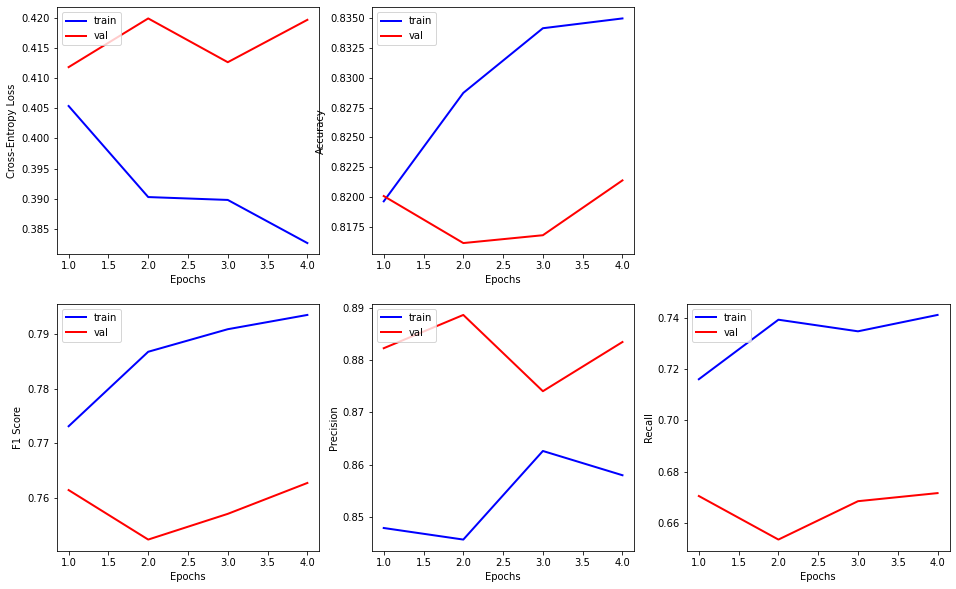

Final training loss:0.38, Final validation loss:0.42
Final training F1-score:79.0%, Final validation F1-score:76.0%
Final training accuracy:83.0%, Final validation accuracy:82.0%


In [ ]:
#generate plots
print('Final LSTM Model Performance')
plot_training(FT_final_model_history)
final_epoch_performance(FT_final_model_history)

We regenerated the best performing FastText model for comparison below.

### Comparison between BERT and FastText Bi-LSTM for tweet classification

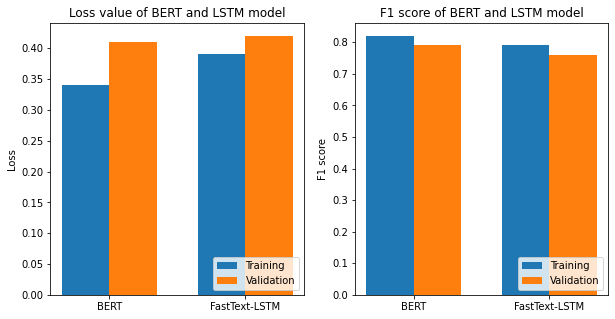

Final BERT Performance
Final training loss:0.34, Final validation loss:0.41
Final training F1-score:82.0%, Final validation F1-score:79.0%
Final training accuracy:87.0%, Final validation accuracy:84.0%


Final FastText-LSTM Performance
Final training loss:0.39, Final validation loss:0.42
Final training F1-score:79.0%, Final validation F1-score:76.0%
Final training accuracy:83.0%, Final validation accuracy:82.0%


In [ ]:
#
num_epoch_BERT = len(BERT_history.history['loss']) - 1
num_epoch_FT = len(FT_final_model_history.history['loss']) - 1

labels = ['BERT', 'FastText-LSTM']
training_loss = [round(BERT_history.history['loss'][num_epoch_BERT],2), round(FT_final_model_history.history['loss'][num_epoch_FT],2)]
validation_loss = [round(BERT_history.history['val_loss'][num_epoch_BERT],2), round(FT_final_model_history.history['val_loss'][num_epoch_FT],2)]
training_f1 = [round(BERT_history.history['f1_m'][num_epoch_BERT],2), round(FT_final_model_history.history['f1_m'][num_epoch_FT],2)]
validation_f1 = [round(BERT_history.history['val_f1_m'][num_epoch_BERT],2), round(FT_final_model_history.history['val_f1_m'][num_epoch_FT],2)]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
rects1 = ax1.bar(x - width/2, training_loss, width, label='Training')
rects2 = ax1.bar(x + width/2, validation_loss, width, label='Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Loss')
ax1.set_title('Loss value of BERT and LSTM model')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='lower right')

rects3 = ax2.bar(x - width/2, training_f1, width, label='Training')
rects4 = ax2.bar(x + width/2, validation_f1, width, label='Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('F1 score')
ax2.set_title('F1 score of BERT and LSTM model')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc='lower right')

plt.show()
print('Final BERT Performance')
final_epoch_performance(BERT_history)
print('\n')
print('Final FastText-LSTM Performance')
final_epoch_performance(FT_final_model_history)

**Comparison between BERT and FastText** 

Overall, BERT is the higher performing model with a final F1 score of 79% . This is 3% higher than the FastText-LSTM model. The higher performance from BERT is as expected, BERT should have better  understanding of language than FastText due to its contextual embeddings. However, it is worth to note that the performance from the FastText model is quite competitive and using the pre-trained FastText embedding and training the LSTM layers was significantly faster than fine-tuning BERT. In the future, we should extend this comparison to more complicated NLP tasks to further assess the capabilities of the two models.


### Does contraction significantly affect performance of the 2 models?

Hypothesis: Expanding contraction should have some effect in helping the model to understand the context. However, the effect on disaster classification might be less. For example, "There's a fire in the woods" and "There is a fire in the woods" produces minimal incremental value in understanding there is a disaster but makes it easier for the reader to read the sentence.

In [ ]:
!pip install contractions

     |████████████████████████████████| 327kB 2.8MB/s 
     |████████████████████████████████| 286kB 4.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85383 sha256=8f347b6f4486adfafe8c46f42034a987993c257893d55736c3ea44d416fac0c5
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
# Apply text cleaning functions
con_train_set = raw_train_set.copy()
con_test_set = raw_test_set.copy()

len(con_train_set)

7613

In [ ]:
import contractions

expanded_text = [None]*7613

for i in range(0,7613):
  expanded_text[i] = contractions.fix(con_train_set['text'][i])

con_train_set['expanded_text'] = pd.Series(expanded_text)
con_train_set['is_same'] = (con_train_set['expanded_text']==con_train_set['text'])

print(f"Contraction changes made: {sum(con_train_set['is_same'] == False)}")
con_train_set[con_train_set['is_same'] == False]

Contraction changes made: 1505


,id,keyword,location,text,target,expanded_text,is_same
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,I am on top of the hill and I can see a fire in the woods...,False
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,there is an emergency evacuation happening now in the building across the street,False
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,I am afraid that the tornado is coming to our area...,False
11,17,NaN,NaN,Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding,1,Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I going to DO WHAT AM I going to DO FVCK #flooding,False
12,18,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count,1,#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I have lost count,False
...,...,...,...,...,...,...,...
7571,10822,wrecked,Glasgow,@Caitsroberts see U the night wee bArra to get absolutely wrecked ????,0,@Caitsroberts see you the night wee bArra to get absolutely wrecked ????,False
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thought the wife who wrecked her cake was a goner mind lol #whoops,0,@widda16 ... he is gone. You can relax. I thought the wife who wrecked her cake was a goner mind lol #whoops,False
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one,0,Three days off from work and they have pretty much all been wrecked hahaha shoutout to my family for that one,False
7602,10860,NaN,NaN,a siren just went off and it wasn't the Forney tornado warning ??,1,a siren just went off and it was not the Forney tornado warning ??,False


1505/7613 (19.8%) of the train-set sentence has been modified for contraction expansion which is a significant amount.

In [ ]:
con_train_set['expanded_text'] = con_train_set['expanded_text'].apply(lambda x: remove_URL(x))
con_train_set['expanded_text'] = con_train_set['expanded_text'].apply(lambda x: remove_emoji(x))
con_train_set['expanded_text'] = con_train_set['expanded_text'].apply(lambda x: remove_html(x))

###### BERT Implementation

In [ ]:
#Train/validation set split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(con_train_set['expanded_text'].tolist(),\
                                                      con_train_set['target'].tolist(),\
                                                      test_size=0.20,\
                                                      stratify = con_train_set['target'].tolist(),\
                                                      random_state=0)

In [ ]:
# Initialise the data-set
seed = 1

train_ds_32 = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
valid_ds_32 = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(32)

# Model settings
n_epoch = 2

steps_per_epoch = tf.data.experimental.cardinality(train_ds_32).numpy()

num_train_steps = steps_per_epoch*n_epoch

num_warmup_steps = int(0.1*num_train_steps)

# Loss Function & Evaluation Metric
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy() , recall_m, precision_m, f1_m]

In [ ]:
BERT_classifier_model_wCon = build_classifier_model()
    
optimizer = optimization.create_optimizer(init_lr=2e-5,
                                          num_train_steps = num_train_steps,
                                          num_warmup_steps = num_warmup_steps,
                                          optimizer_type = 'adamw')
    
BERT_classifier_model_wCon.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
    
print(f'Training model with {tfhub_handle_encoder}, Batch-size: {32}, Learning rate: {2e-5}')
BERT_history_wCon = BERT_classifier_model_wCon.fit(x=train_ds_32, validation_data=valid_ds_32, epochs=2)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3, Batch-size: 32, Learning rate: 2e-05
Epoch 1/2
191/191 [==============================] - 89s 375ms/step - loss: 0.5491 - binary_accuracy: 0.7138 - recall_m: 0.4827 - precision_m: 0.7573 - f1_m: 0.5554 - val_loss: 0.4104 - val_binary_accuracy: 0.8372 - val_recall_m: 0.7771 - val_precision_m: 0.8288 - val_f1_m: 0.7970
Epoch 2/2
191/191 [==============================] - 71s 370ms/step - loss: 0.3516 - binary_accuracy: 0.8553 - recall_m: 0.7363 - precision_m: 0.9145 - f1_m: 0.8090 - val_loss: 0.4055 - val_binary_accuracy: 0.8444 - val_recall_m: 0.7343 - val_precision_m: 0.8778 - val_f1_m: 0.7937


BERT final model Vs. BERT with expanded contraction


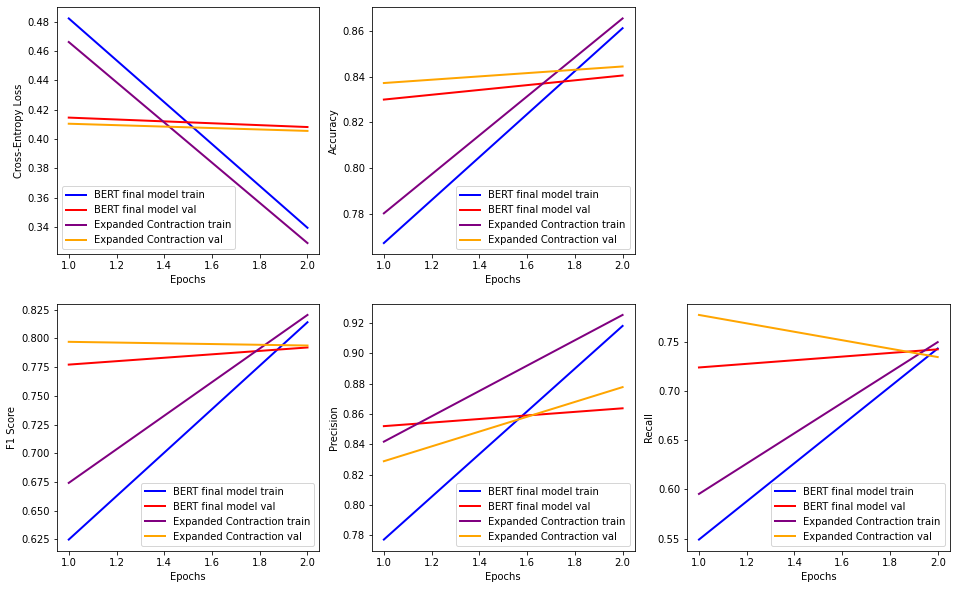

Final BERT model:
Final training loss:0.34, Final validation loss:0.41
Final training F1-score:81.0%, Final validation F1-score:79.0%
Final training accuracy:86.0%, Final validation accuracy:84.0%


BERT with expanded contraction:
Final training loss:0.33, Final validation loss:0.41
Final training F1-score:82.0%, Final validation F1-score:79.0%
Final training accuracy:87.0%, Final validation accuracy:84.0%


In [ ]:
print('BERT final model Vs. BERT with expanded contraction')
compare_models_FT(BERT_history, BERT_history_wCon, 'BERT final model', 'Expanded Contraction',
                  'lower left','lower right','lower right','lower right','lower right')

print('Final BERT model:')
final_epoch_performance(BERT_history)
print('\n')
print('BERT with expanded contraction:')
final_epoch_performance(BERT_history_wCon)

The results show that expanding contractions has a negative effect on the performance of BERT. However, the magnitude is very insignificant. Therefore it is safe to conclude that contractions do not affect BERT's performance to disaster tweet classification.

######FastText LSTM Implementation

In [ ]:
raw_docs_train = con_train_set['text'].tolist()
raw_docs_test = cleaned_test_set['text'].tolist() 

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
con_train_set['tweet_length'] = con_train_set['text'].apply(lambda words: len(words.split(" ")))
percentile_seq_len = np.percentile(con_train_set['tweet_length'],99).astype(int)
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=percentile_seq_len)

  6%|▌         | 455/7613 [00:00<00:01, 4548.15it/s]

pre-processing train data...


100%|██████████| 7613/7613 [00:01<00:00, 4119.50it/s]


tokenizing input data...
dictionary size:  22258


In [ ]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#embedding matrix
print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 10094


In [ ]:
LSTM_modelwCon = tf.keras.Sequential(name='Final_LSTM_model_wContraction')
LSTM_modelwCon.add(Embedding(nb_words,embed_dim,input_length=percentile_seq_len, weights=[embedding_matrix],trainable=False, name = 'FastText'))
LSTM_modelwCon.add(Dropout(0.3, name = 'Dropout_1'))
LSTM_modelwCon.add(Bidirectional(LSTM(64,return_sequences= False), name = 'Bi-LSTM'))
LSTM_modelwCon.add(Dense(32,activation='relu'))
LSTM_modelwCon.add(Dropout(0.3, name = 'Dropout_2'))
LSTM_modelwCon.add(Dense(1,activation='sigmoid', name = 'Classifier_layer'))
LSTM_modelwCon.summary()

Model: "Final_LSTM_model_wContraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FastText (Embedding)         (None, 27, 300)           6677700   
_________________________________________________________________
Dropout_1 (Dropout)          (None, 27, 300)           0         
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 128)               186880    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
Dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
Classifier_layer (Dense)     (None, 1)                 33        
Total params: 6,868,741
Trainable params: 191,041
Non-trainable params: 6,677,700
_____________________

In [ ]:
LSTM_modelwCon.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics)

es_callback = EarlyStopping(monitor='val_loss', patience=5)

LSTMwCon_history = LSTM_modelwCon.fit(word_seq_train, con_train_set['target'], batch_size=256,
          epochs=num_epochs, validation_split=0.2, callbacks=[es_callback], shuffle=False)

Epoch 1/40
24/24 [==============================] - 5s 58ms/step - loss: 0.6773 - binary_accuracy: 0.6729 - recall_m: 0.1186 - precision_m: 0.2493 - f1_m: 0.1387 - val_loss: 0.6205 - val_binary_accuracy: 0.7334 - val_recall_m: 0.6082 - val_precision_m: 0.7321 - val_f1_m: 0.6609
Epoch 2/40
24/24 [==============================] - 0s 15ms/step - loss: 0.5813 - binary_accuracy: 0.7272 - recall_m: 0.5084 - precision_m: 0.6964 - f1_m: 0.5551 - val_loss: 0.4639 - val_binary_accuracy: 0.7905 - val_recall_m: 0.6886 - val_precision_m: 0.7965 - val_f1_m: 0.7341
Epoch 3/40
24/24 [==============================] - 0s 14ms/step - loss: 0.4568 - binary_accuracy: 0.8050 - recall_m: 0.6388 - precision_m: 0.7598 - f1_m: 0.6873 - val_loss: 0.4329 - val_binary_accuracy: 0.8122 - val_recall_m: 0.6490 - val_precision_m: 0.8946 - val_f1_m: 0.7387
Epoch 4/40
24/24 [==============================] - 0s 15ms/step - loss: 0.4358 - binary_accuracy: 0.8123 - recall_m: 0.6283 - precision_m: 0.8175 - f1_m: 0.6984 -

FastText final model Vs. FastText with expanded contraction


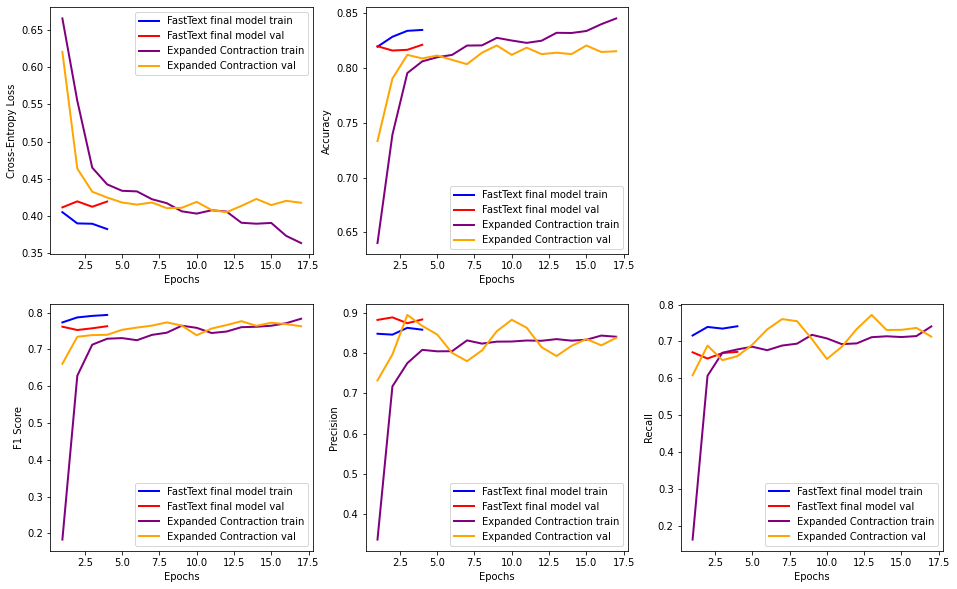

Final FastText model:
Final training loss:0.38, Final validation loss:0.42
Final training F1-score:79.0%, Final validation F1-score:76.0%
Final training accuracy:83.0%, Final validation accuracy:82.0%


FastText with expanded contraction:
Final training loss:0.36, Final validation loss:0.42
Final training F1-score:78.0%, Final validation F1-score:76.0%
Final training accuracy:85.0%, Final validation accuracy:82.0%


In [ ]:
print('FastText final model Vs. FastText with expanded contraction')
compare_models_FT(FT_final_model_history, LSTMwCon_history, 'FastText final model', 'Expanded Contraction',
                  'upper right','lower right','lower right','lower right','lower right')

print('Final FastText model:')
final_epoch_performance(FT_final_model_history)
print('\n')
print('FastText with expanded contraction:')
final_epoch_performance(LSTMwCon_history)

The result shows expanding contractions do not improve model performance. Specifically, the model performance with expanded contractions performed the same when compared with our previous final model. However, the training of the contraction model started with a much higher loss but it improved quickly after a few epochs.

###### Summary

Contraction expansion might help to reduce computation cost since words will be in the vocabulary of the model but does not bring benefit , in the case of disaster tweet classification.

### Does misspelled words affect performance of the 2 models?

Hypothesis:<br>For our case of disaster tweet classification, misspellings should have some effect on the performance of the models. it is reasonable to expect if key disaster words are misspelled then the performance should be significantly affected. <br> <br> For example with BERT, since it uses WordPiece tokenisation, misspelled words would be broken down to components already in the dictionary. E.g. if we have the phrase, "Massive landslide in..." and a misspelling occurs, "landslide" becomes "lsndslide". The tokenisation process will break down this word to sub-tokens such as "l", "s", "n", "d" , "slide"(Exact tokenisation depends on the vocabulary list).  The generated embeddings would be very different to "landslide" which would affect the classification results. <br> <br>
FastText might be less affected due to the use of character n-gram vectors as well as the whole word vector. Using the same example above, the word vector for "lsndslide" in FastText implementation should be comprised of the individual vector of "lsndslide" and character n-grams vectors of "<ls", "snd", "nds", "dsl",..., "de>" (as a working example). While the whole word vector and the first and second 3-grams vectors are affected, the rest of the 3-grams vector are not affected. This could mean the effect of misspellings on FastText model is less. <br><br>

Experiment:
In this part, we assume we had a perfect training set where there is minimal misspellings but the validation set contains significant spelling mistakes. We want to simulate the environment where we had quality assurance for the training data but due to time constraint of responding to real-time disaster tweet, the preparation of real-time data for prediction is limited.

In [ ]:
# Apply text cleaning functions
misspelled_train_set = raw_train_set.copy()

len(misspelled_train_set)

7613

In [ ]:
# Manipulate the original text
freq = 0.4

apply_misspelled = ['']*len(misspelled_train_set)

# For a simple test, we manipulate the letter 'a' 
# with characters that are next to it on an English keyboard.
# This is to simulate typing mistakes.

for i in range(0,len(misspelled_train_set)):
  for j in misspelled_train_set['text'][i]:
    if j == 'a' and random.random() < freq :
      random_number = random.random()
      if random_number <= 0.25:
        letter_replacement = 'q'
      elif random_number > 0.25 and random_number <=  0.50:
        letter_replacement =  'w'
      elif random_number > 0.50 and random_number <= 0.75:
        letter_replacement =  's'
      else:
        letter_replacement =  'z'
      apply_misspelled[i] += letter_replacement
    else:
      apply_misspelled[i] += j
      
print(misspelled_train_set['text'][0])
print(apply_misspelled[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Our Deeds qre the Reason of this #ewrthquwke Msy ALLAH Forgive us qll


In [ ]:
misspelled_train_set['misspelled_text'] = pd.Series(apply_misspelled)
misspelled_train_set['is_same'] = (misspelled_train_set['misspelled_text']==misspelled_train_set['text'])

print(f"Misspelled tweets made: {sum(misspelled_train_set['is_same'] == False)}, Proportion of tweets that have mispellings:{round(sum(misspelled_train_set['is_same'] == False)/len(misspelled_train_set),3)*100}%" )
misspelled_train_set[misspelled_train_set['is_same'] == False]

Misspelled tweets made: 6426, Proportion of tweets that have mispellings:84.39999999999999%


,id,keyword,location,text,target,misspelled_text,is_same
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds qre the Reason of this #ewrthquwke Msy ALLAH Forgive us qll,False
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire neqr La Ronge Sask. Cznada,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in plzce' sre being notified by officers. No other evacuztion or shelter in plsce orders are expected,False
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alwsks zs smoke from #wildfires pours into a school,False
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,#RockyFire Update => Cqlifornia Hwy. 20 closed in both directions due to Lwke County fire - #CAfire #wildfires,False
...,...,...,...,...,...,...,...
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1,#stormchase Violent Record Breaking EF-5 El Reno Oklqhoma Tornado Nezrly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Ow0HISp,False
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,@ariw_ahrqry @TheTawniest The out of control wild fires in Cqliforniq even in the Northern part of the stzte. Very troubling.,False
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,M1.94 [01:04 UTC]?5km S of Volcwno Hswzii. http://t.co/zDtoyd8EbJ,False
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigqting after sn e-bike collided with a csr in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,False


In [ ]:
misspelled_train_set['misspelled_text'] = misspelled_train_set['misspelled_text'].apply(lambda x: remove_URL(x))
misspelled_train_set['misspelled_text'] = misspelled_train_set['misspelled_text'].apply(lambda x: remove_emoji(x))
misspelled_train_set['misspelled_text'] = misspelled_train_set['misspelled_text'].apply(lambda x: remove_html(x))

###### BERT Implementation

In [ ]:
#Train/validation set split
from sklearn.model_selection import train_test_split
X_train_ms, X_valid_ms, y_train_ms, y_valid_ms = train_test_split(misspelled_train_set['misspelled_text'].tolist(),\
                                                      misspelled_train_set['target'].tolist(),\
                                                      test_size=0.20,\
                                                      stratify = misspelled_train_set['target'].tolist(),\
                                                      random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(cleaned_train_set['text'].tolist(),\
                                                      cleaned_train_set['target'].tolist(),\
                                                      test_size=0.20,\
                                                      stratify = cleaned_train_set['target'].tolist(),\
                                                      random_state=0)

print(X_valid_ms[5])
print(X_valid[5])

You are equally as scqred cause this somehow stsrted to heal you fill your wounds that you once thought were permanent.
You are equally as scared cause this somehow started to heal you fill your wounds that you once thought were permanent.


In [ ]:
# Initialise the data-set
seed = 1

train_ds_32 = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
valid_ds_32 = tf.data.Dataset.from_tensor_slices((X_valid_ms,y_valid_ms)).batch(32)

# Model settings
n_epoch = 3

steps_per_epoch = tf.data.experimental.cardinality(train_ds_32).numpy()

num_train_steps = steps_per_epoch*n_epoch

num_warmup_steps = int(0.1*num_train_steps)


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
BERT_classifier_model_wMisspelled = build_classifier_model()
    
optimizer = optimization.create_optimizer(init_lr=2e-5,
                                          num_train_steps = num_train_steps,
                                          num_warmup_steps = num_warmup_steps,
                                          optimizer_type = 'adamw')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

BERT_classifier_model_wMisspelled.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
    
print(f'Training model with {tfhub_handle_encoder}, Batch-size: {32}, Learning rate: {2e-5}')
BERT_history_wMisspelled = BERT_classifier_model_wMisspelled.fit(x=train_ds_32, validation_data=valid_ds_32, epochs=2)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3, Batch-size: 32, Learning rate: 2e-05
Epoch 1/2
191/191 [==============================] - 126s 584ms/step - loss: 0.5825 - binary_accuracy: 0.7587 - recall_m: 0.3466 - precision_m: 0.5494 - f1_m: 0.4057 - val_loss: 0.4403 - val_binary_accuracy: 0.8076 - val_recall_m: 0.6778 - val_precision_m: 0.8355 - val_f1_m: 0.7434
Epoch 2/2
191/191 [==============================] - 111s 580ms/step - loss: 0.3742 - binary_accuracy: 0.8399 - recall_m: 0.7161 - precision_m: 0.8959 - f1_m: 0.7884 - val_loss: 0.4551 - val_binary_accuracy: 0.8201 - val_recall_m: 0.7362 - val_precision_m: 0.8227 - val_f1_m: 0.7710


BERT final model vs. mis-spelled version


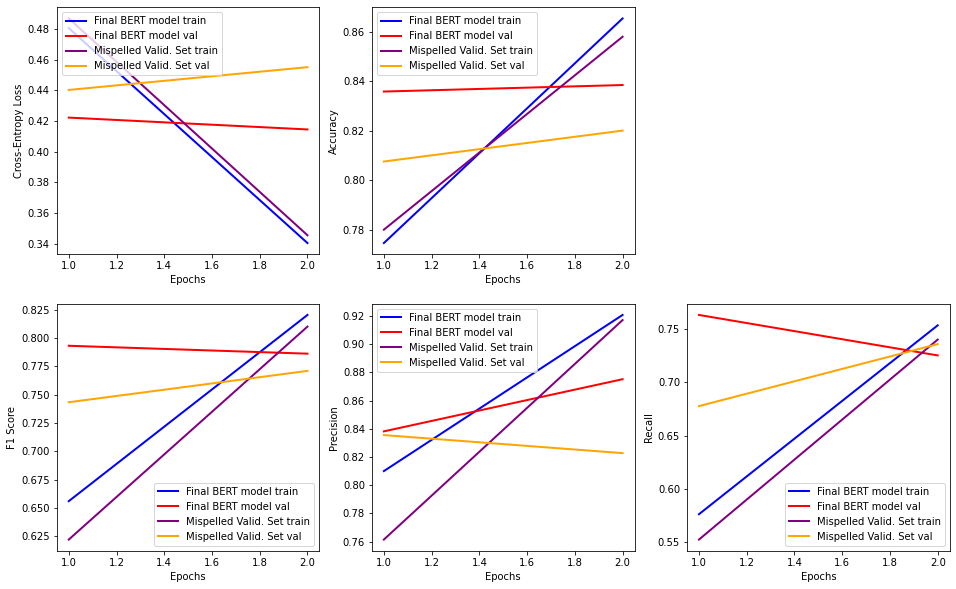

Final BERT model:
Final training loss:0.34, Final validation loss:0.41
Final training F1-score:82.0%, Final validation F1-score:79.0%
Final training accuracy:87.0%, Final validation accuracy:84.0%


BERT with mispelled words :
Final training loss:0.35, Final validation loss:0.46
Final training F1-score:81.0%, Final validation F1-score:77.0%
Final training accuracy:86.0%, Final validation accuracy:82.0%


In [ ]:
print('BERT final model vs. mis-spelled version')
compare_models_FT(BERT_history,BERT_history_wMisspelled,"Final BERT model","Mispelled Valid. Set",
                  'upper left','upper left','lower right','upper left','lower right')

#plot_training(BERT_history_wMisspelled,3)
print('Final BERT model:')
final_epoch_performance(BERT_history)
print('\n')
print('BERT with mispelled words :')
final_epoch_performance(BERT_history_wMisspelled)

Here we briefly compare the results, BERT is surprisingly robust with the random misspellings. With our current paramter settings, 84% of the tweets in our dataset is affected with misspellings of the 'a' character but it only  decreased the validation F1-score by 2%. Perhaps, significant effect to the prediction only occurs if the key disaster word is affected. Below, we experiment with that.

In [ ]:
# Let's experiment a number of misspelled samples, in particular changing some
# 
misspelled_test = [
    'earthquake at midnight',  
    'ezrthquake at midnight',
    'forest fire in July',
    'forest flre in July',
    'landslide during summer',
    'lsndslide during summer',
    'landslide during monsoon season',
    'lsndslide during monsoon season',
    'lsndslide during monzoon season',       
    'just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school',
    'just got sent this photo from Ruby #Alaska as zmoke from #wildfires pours into a school',
    'just got sent this photo from Ruby #Alwsks zs zmoke from #wildflres pours into a school'
]


In [ ]:
# Use final BERT model to make prediction to test cases
# As an illustration the first number is 0.9779, this
# indicates there is a 97.8% chance that the first phrase in misspelled_test is a disaster tweet
final_results = tf.sigmoid(BERT_classifier_model(tf.convert_to_tensor(misspelled_test)))
final_results

<tf.Tensor: shape=(12, 1), dtype=float32, numpy=
array([[0.9779067 ],
       [0.08943941],
       [0.9782516 ],
       [0.35342836],
       [0.9744367 ],
       [0.19941373],
       [0.9584874 ],
       [0.9343028 ],
       [0.14860389],
       [0.9709655 ],
       [0.9733078 ],
       [0.10152356]], dtype=float32)>

The above results show if misspelling occurs to keywords in a tweet, the prediction is hugely affected. Confirming our hypothesis.

######FastText LSTM Implementation

In [ ]:
raw_docs_train = cleaned_train_set['text'].tolist()
raw_docs_train_ms = misspelled_train_set['misspelled_text'].tolist()
spelling_test_set = misspelled_test

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

processed_docs_train_ms = []
for doc in tqdm(raw_docs_train_ms):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train_ms.append(" ".join(filtered))

processed_misspelled = []
for doc in tqdm(spelling_test_set):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_misspelled.append(" ".join(filtered))

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train+processed_docs_train_ms)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_train_ms = tokenizer.texts_to_sequences(processed_docs_train_ms)
word_seq_misspelled = tokenizer.texts_to_sequences(processed_misspelled)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
misspelled_train_set['tweet_length'] = misspelled_train_set['misspelled_text'].apply(lambda words: len(words.split(" ")))
percentile_seq_len = np.percentile(misspelled_train_set['tweet_length'],99).astype(int)
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=percentile_seq_len)
word_seq_train_ms = sequence.pad_sequences(word_seq_train_ms, maxlen=percentile_seq_len)
word_seq_misspelled_test = sequence.pad_sequences(word_seq_misspelled, maxlen=percentile_seq_len)

  9%|▊         | 651/7613 [00:00<00:01, 6507.51it/s]

pre-processing train data...


100%|██████████| 12/12 [00:00<00:00, 4324.77it/s]


tokenizing input data...
dictionary size:  25381


In [ ]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#embedding matrix
print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 13066


In [ ]:
LSTM_modelwMS = tf.keras.Sequential(name='Final_LSTM_model_wContraction')
LSTM_modelwMS.add(Embedding(nb_words,embed_dim,input_length=percentile_seq_len, weights=[embedding_matrix],trainable=False, name = 'FastText'))
LSTM_modelwMS.add(Dropout(0.3, name = 'Dropout_1'))
LSTM_modelwMS.add(Bidirectional(LSTM(64,return_sequences= False), name = 'Bi-LSTM'))
LSTM_modelwMS.add(Dense(32,activation='relu'))
LSTM_modelwMS.add(Dropout(0.3, name = 'Dropout_2'))
LSTM_modelwMS.add(Dense(1,activation='sigmoid', name = 'Classifier_layer'))
LSTM_modelwMS.summary()

Model: "Final_LSTM_model_wContraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FastText (Embedding)         (None, 27, 300)           7614600   
_________________________________________________________________
Dropout_1 (Dropout)          (None, 27, 300)           0         
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 128)               186880    
_________________________________________________________________
dense_15 (Dense)             (None, 32)                4128      
_________________________________________________________________
Dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
Classifier_layer (Dense)     (None, 1)                 33        
Total params: 7,805,641
Trainable params: 191,041
Non-trainable params: 7,614,600
_____________________

In [ ]:
word_seq_train

array([[   0,    0,    0, ..., 1669, 4783,   33],
       [   0,    0,    0, ..., 7696, 7697, 1639],
       [   0,    0,    0, ...,  796, 1301,  993],
       ...,
       [   0,    0,    0, ...,   51,  659, 1853],
       [   0,    0,    0, ...,   65, 2201,  246],
       [   0,    0,    0, ...,  101,  563,   13]], dtype=int32)

In [ ]:
#Train/validation set split
X_train_ms, X_valid_ms, y_train_ms, y_valid_ms = train_test_split(word_seq_train_ms.tolist(),\
                                                      misspelled_train_set['target'].tolist(),\
                                                      test_size=0.20,\
                                                      stratify = misspelled_train_set['target'].tolist(),\
                                                      random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(word_seq_train.tolist(),\
                                                      cleaned_train_set['target'].tolist(),\
                                                      test_size=0.20,\
                                                      stratify = cleaned_train_set['target'].tolist(),\
                                                      random_state=0)

print(X_valid_ms[5])
print(X_valid[5])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 5908, 7526, 328, 2145, 25285, 3821, 2593, 386, 440, 5984]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 5908, 1193, 328, 2145, 1224, 3821, 2593, 386, 440, 5984]


In [ ]:
train_ds_256 = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(256)
valid_ds_256 = tf.data.Dataset.from_tensor_slices((X_valid_ms,y_valid_ms)).batch(256)

In [ ]:
LSTM_modelwMS.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics)

es_callback = EarlyStopping(monitor='val_loss', patience=5)

LSTMwMS_history = LSTM_modelwMS.fit(x=train_ds_256,validation_data=valid_ds_256,
          epochs=40, callbacks=[es_callback])


Epoch 1/40
24/24 [==============================] - 4s 44ms/step - loss: 0.6751 - binary_accuracy: 0.6909 - recall_m: 0.3365 - precision_m: 0.5977 - f1_m: 0.3813 - val_loss: 0.5356 - val_binary_accuracy: 0.7446 - val_recall_m: 0.5274 - val_precision_m: 0.8151 - val_f1_m: 0.6397
Epoch 2/40
24/24 [==============================] - 0s 13ms/step - loss: 0.5118 - binary_accuracy: 0.7717 - recall_m: 0.6801 - precision_m: 0.7696 - f1_m: 0.7185 - val_loss: 0.4842 - val_binary_accuracy: 0.7715 - val_recall_m: 0.5462 - val_precision_m: 0.8727 - val_f1_m: 0.6712
Epoch 3/40
24/24 [==============================] - 0s 13ms/step - loss: 0.4515 - binary_accuracy: 0.8101 - recall_m: 0.7102 - precision_m: 0.8285 - f1_m: 0.7632 - val_loss: 0.4675 - val_binary_accuracy: 0.7794 - val_recall_m: 0.5801 - val_precision_m: 0.8577 - val_f1_m: 0.6911
Epoch 4/40
24/24 [==============================] - 0s 12ms/step - loss: 0.4480 - binary_accuracy: 0.8052 - recall_m: 0.7096 - precision_m: 0.8191 - f1_m: 0.7586 -

FastText final model Vs. FastText with misspelled validation set


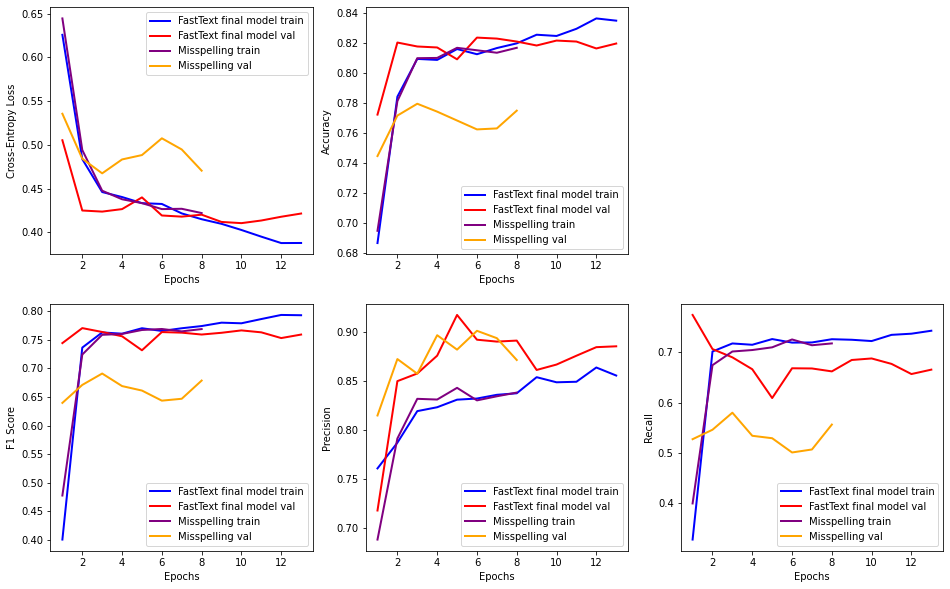

FastText final model:
Final training loss:0.39, Final validation loss:0.42
Final training F1-score:79.0%, Final validation F1-score:76.0%
Final training accuracy:83.0%, Final validation accuracy:82.0%


FastText with misspelling validation set:
Final training loss:0.42, Final validation loss:0.47
Final training F1-score:77.0%, Final validation F1-score:68.0%
Final training accuracy:82.0%, Final validation accuracy:77.0%


In [ ]:
print('FastText final model Vs. FastText with misspelled validation set')
compare_models_FT(FT_final_model_history, LSTMwMS_history, 'FastText final model', 'Misspelling',
                  'upper right','lower right','lower right','lower right','lower right')

print('FastText final model:')
final_epoch_performance(FT_final_model_history)
print('\n')
print('FastText with misspelling validation set:')
final_epoch_performance(LSTMwMS_history)

The above results indicate that FastText model is more affected by the random misspellings than BERT as the validation score suffers a 8% decrease. The decrease comes from the decrease in recall. This seems reasonable, our misspellings are more likely to make disaster words disappear than creating more disaster related words. Hence, more false negative cases should appear. It is unclear why FastText significantly more affected than BERT. One hypothesis is that there are tweets where multiple keywords are present, our mispellings might only affect one of those keywords and BERT is more robust when multiple keywords are present. However, we shall leave this to be tested in future works.

In [ ]:
# Display the tested phrases
misspelled_test

['earthquake at midnight',
 'ezrthquake at midnight',
 'forest fire in July',
 'forest flre in July',
 'landslide during summer',
 'lsndslide during summer',
 'landslide during monsoon season',
 'lsndslide during monsoon season',
 'lsndslide during monzoon season',
 'just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school',
 'just got sent this photo from Ruby #Alaska as zmoke from #wildfires pours into a school',
 'just got sent this photo from Ruby #Alwsks zs zmoke from #wildflres pours into a school']

In [ ]:
# Make prediction to phrases, >50% means disaster tweet prediction
LSTM_modelwMS(word_seq_misspelled_test)

<tf.Tensor: shape=(12, 1), dtype=float32, numpy=
array([[0.65330404],
       [0.15287223],
       [0.8949477 ],
       [0.6309638 ],
       [0.68465185],
       [0.20108187],
       [0.93103874],
       [0.6380298 ],
       [0.15530582],
       [0.9572085 ],
       [0.9511546 ],
       [0.18875122]], dtype=float32)>

The observed change are similar to what we have seen with BERT. If misspelling affect keywords, the prediction is significantly affected. It is interesting to see that for the 3rd and 4th predictions, the misspelling would not have changed the prediction. This could be supporting evidence for what we hypothesize. Again, due to time constraint, we will have to leave this to future works to confirm.

###### Summary

Results from random letter "a" replacement

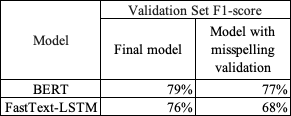

Results from testing with individual text:

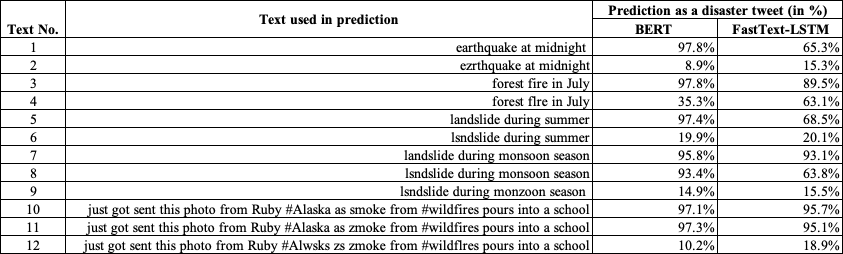

In summary, BERT is robust against random misspellings but FastText-LSTM is not. This is indicated by the difference in validation F1-scores in the first table. Both models are significantly affected by keyword misspellings indicated in the second table. Looking at the difference in prediction values, the changes in BERT prediction is significantly higher than FastText. For example, the difference in BERT's predictions for text 1 and 2 is -88.9%, the difference in FastText's predictions for the same texts is -50%. Both models would make a false negative prediction here, but the misspelling does seem to affect the FastText model less if we look at the percentages. Furthermore, if we look at text 3 and 4, FastText was able to correctly identify the text even after the misspelling (given the decision boundary is at 50%). This further support FastText is more robust against misspellings on keywords. However, we should create more examples to validate this claim in future works.

##7 Final Conclusion

After fine-tuning and some hyperparameter search, our best performing BERT model had a batch size of 32, an initial learning rate of 2e-5, 2 epochs and 10% dropout. This yielded a final F1 score of 79%. We experimented with higher dropout after the encoder layers but it did not improve performance. We should also change the dropout parameters within the encoder layers to further assess possible performance improvement in future works. <br> <br>

For the FastText implementation, we used the pre-trained FastText embeddings with LSTM layers. We introduced dropout layers and early stopping to improve the final performance. The final model had a validation F1-score of 76%, a competitive score to the BERT implementation. We experimented with adding more LSTM layers, but it did not improve the performance. <br><br>

In general, BERT is the higher-performing model, but FastText implementation requires less training time.<br><br>

Furthermore, we test model performances with expanding contraction and manipulated tweets with misspellings. Our results show expanding contractions had minimal effects on the implementation of disaster tweet classification. BERT is more robust with random misspellings in a tweet. Both models suffered when misspellings occur in key disaster words. However, there is some evidence to suggest it affects the FastText model less.

## 8 Further work

Through our analysis, we identified several areas where further research will be beneficial. To compare the two different models more comprehensively, we should extend our classification task on several different datasets and classification tasks. Namely, we should use the binary classifications task within the GLUE benchmark. <br> <br>

We should also further experiment with different network architectures after the embedding layers,such as adding CNN layers or simple dense layers, to find the best performing configuration for both models. <br> <br>

Finally, we should further study how natural misspelling occurs with human users and try to mimic that for our experiment to truly assess the realistic impact to model performances.

## 9 References

[1] J. Devlin, M.W. Chang, K. Lee, K. Toutanova, [BERT:Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf), 2019 <br>
[2] C. Sun, X. Qiu, Y. Xu and X. Huang. [*How to Fine-Tune BERT for Text Classification?*](https://arxiv.org/pdf/1905.05583.pdf), 2020<br>
[3] Z. Ashktorab, C. Brown, M. Nandi and A. Culotta, [*Tweedr: Mining Twitter to Inform Disaster Response*](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.2784&rep=rep1&type=pdf), 2014 <br>
[4] Md. Y. Kabir and S. Madria. [*A Deep Learning Approach for Tweet Classification and Rescue Scheduling for Effective Disaster Management (Industrial)*](https://arxiv.org/pdf/1908.01456.pdf), 2019 <br>
[5] L. Sun, K. Hashimoto, W. Yin, A. Asai, J. Li, P. Yu and C. Xiong. [*Adv-BERT: BERT is not robust on misspellings!
Generating nature adversarial samples on BERT*](https://arxiv.org/pdf/2003.04985.pdf), 2020 <br>
[6] L. Torrey, J. Shavlik, [Chapter 11: Transfer Learning, Handbook of Research on Machine Learning Applications](ftp://ftp.cs.wisc.edu/machine-learning/shavlik-group/torrey.handbook09.pdf), 2009 <br>
[7] A. Vaswani, N. Shazeer, N. Parmar, j. Uszkoreit, L. Jones, A. Gomez, L. Kaiser, I. Polosukhin, [Attention Is all You Need](https://arxiv.org/pdf/1706.03762.pdf), 2017 <br>
